<h1 align="center"> 0.0 Initialization </h1> 


Import needed packages

In [1]:
import pandas as pd
import numpy as np
from sodapy import Socrata
import pickle
import urllib.request
import zipfile
import geopandas as gpd
import shapefile
import math
import json
import os
from functools import reduce
from IPython.display import Image

import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl
import matplotlib.patches as mpatches

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import r2_score

from shapely.geometry import Polygon

from plotly import graph_objs as go
from plotly.offline import init_notebook_mode, iplot
import plotly.express as px

import plotly.io as pio
pio.renderers.default = "png"
#pio.renderers.default = "notebook"


# bokeh imports
from bokeh.io import output_notebook, show, output_file, save,export_png
from bokeh.io.doc import curdoc
from bokeh.plotting import figure, output_file, show, reset_output
from bokeh.models import Panel, Tabs
from bokeh.models import NumeralTickFormatter, LogColorMapper
from bokeh.models import Slider, HoverTool, Select, Column
from bokeh.models import (CDSView, ColorBar, ColumnDataSource,
                          CustomJS, CustomJSFilter, 
                          GeoJSONDataSource, HoverTool,
                          CategoricalColorMapper, Slider)
from bokeh.models import (BasicTicker,
                          PrintfTickFormatter,
                          FactorRange)
from bokeh.palettes import Plasma
from bokeh.application import Application
from bokeh.application.handlers import FunctionHandler
from bokeh.layouts import column, row, widgetbox
from bokeh.embed import file_html
from bokeh.resources import CDN
from bokeh.tile_providers import STAMEN_TONER, get_provider


import warnings
warnings.filterwarnings('ignore')


<h1 align="center"> 0.1 Load data </h1> 

We are using all data from 2020 thereby this results in a very large dataset of 24.6M rows. This is used for visualizations in  both this notebook but also for the website. If you run the code you might need to remove some of the months as running with the full dataset requires a lot of available RAM on your computer. 

In [2]:
#-------------------------------------------------------------------------------
# Helper functions

#This is taken from: https://chih-ling-hsu.github.io/2018/05/14/NYC
def get_lat_lon(sf):
    content = []
    for sr in sf.shapeRecords():
        shape = sr.shape
        rec = sr.record
        loc_id = rec[shp_dic['LocationID']]
        
        x = (shape.bbox[0]+shape.bbox[2])/2
        y = (shape.bbox[1]+shape.bbox[3])/2
        
        content.append((loc_id, x, y))
    return pd.DataFrame(content, columns=["LocationID", "longitude", "latitude"])


#--------------------------------------------------------------------------------
# Data loading and preprocessing

date_parser = pd.to_datetime
datatype_dict = {'VendorID': float,
                 'tpep_pickup_datetime': str,
                 'tpep_dropoff_datetime': str,
                 'passenger_count': float,
                 'trip_distance': float,
                 'RatecodeID': float,
                 'store_and_fwd_flag': str,
                 'PULocationID': float,
                 'DOLocationID': float,
                 'payment_type': float,
                 'fare_amount':float,
                 'extra': float,
                 'mta_tax': float,
                 'tip_amount': float,
                 'tolls_amount': float,
                 'improvement_surcharge': float,
                 'total_amount': float,
                 'congestion_surcharge': float}

parse_dates = ['tpep_pickup_datetime', 'tpep_dropoff_datetime']

if os.path.isfile('2020_data.pkl') == False:

    #data_path = 'C://Users/nicol/Google Drev/DTU/MMC/Social dataanlyse og visualisering/socialdata2021/project/data/'
    data_path = 'https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2020-'

    #data_files = os.listdir(data_path)

    data1 = '01.csv'
    data2 = '02.csv'
    data3 = '03.csv'
    data4 = '04.csv'
    data5 = '05.csv'
    data6 = '06.csv'
    data7 = '07.csv'
    data8 = '08.csv'
    data9 = '09.csv'
    data10 = '10.csv'
    data11 = '11.csv'
    data12 = '12.csv'

    data_files = [data1,data2,data3,data4,data5,data6,data7,data8,data9,data10,data11,data12]

    df = pd.read_csv(data_path + data_files[0], dtype = datatype_dict, parse_dates = parse_dates)#, nrows = 1000000) #


    for file in data_files[1:]:
        df = pd.concat([df, pd.read_csv(data_path + file, dtype = datatype_dict, parse_dates = parse_dates)])#, nrows = 1000000)]) #

    df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime 
    df['duration'] =  df['duration'].apply(lambda x: x.seconds)
    df['duration'] = df['duration'].div(3600)
    
    df['pickup_hour'] = df.tpep_pickup_datetime.dt.hour
    df['dropoff_hour'] = df.tpep_dropoff_datetime.dt.hour
    df['pickup_dayofweek'] = df.tpep_pickup_datetime.dt.weekday +1
    df['dropoff_dayofweek'] = df.tpep_dropoff_datetime.dt.weekday+1
    df['pickup_hourofweek'] = (df.pickup_dayofweek-1)*24  + df.pickup_hour.astype(int)+1
    df['dropoff_hourofweek'] = (df.dropoff_dayofweek-1)*24  + df.dropoff_hour.astype(int)+1

    df.to_pickle('2020_data.pkl')
    
    
else:
    df = pd.read_pickle("2020_data.pkl")


##################################################### The data loading function are done by Nicolai ###################################################################

In [3]:
#--------------------------------------------------------------------------------
# Download location data

#This is taken from: https://chih-ling-hsu.github.io/2018/05/14/NYC
if os.path.isfile('shape/taxi_zones.shp') == False:

  urllib.request.urlretrieve("https://s3.amazonaws.com/nyc-tlc/misc/taxi_zones.zip", "taxi_zones.zip")

  with zipfile.ZipFile("taxi_zones.zip","r") as zip_ref:
      zip_ref.extractall("./shape")

sf = shapefile.Reader("shape/taxi_zones.shp")
fields_name = [field[0] for field in sf.fields[1:]]

shp_dic = dict(zip(fields_name, list(range(len(fields_name)))))
attributes = sf.records()
shp_attr = [dict(zip(fields_name, attr)) for attr in attributes]

df_loc = gpd.GeoDataFrame(shp_attr).join(get_lat_lon(sf).set_index("LocationID"), on="LocationID")
df_loc.head()


shh = []
for sr in sf.shapeRecords():
  shape = sr.shape
  rec = sr.record
  loc_id = rec[shp_dic['LocationID']]
  zone = rec[shp_dic['zone']]
  shh.append((Polygon(shape.points), loc_id))

shh_d = gpd.GeoDataFrame(shh, columns = ['shapefile','LocationID']).set_index('LocationID')
df_loc = df_loc.set_index('LocationID')
df_loc= df_loc[~df_loc.index.duplicated(keep='first')]
df_loc = df_loc.reset_index(drop = False)


df_loc = (df_loc.set_index('LocationID')).merge(shh_d, how ='inner', on = 'LocationID')
df_loc = df_loc.reset_index(drop = False)

#---------------------------------------------------------------------------------
# Map taxi zone codes to location data + compute temporal data

borough_mapping = dict(zip(df_loc.LocationID, df_loc.borough))
zone_mapping = dict(zip(df_loc.LocationID, df_loc.zone))

df['PUborough'] = df['PULocationID'].map(borough_mapping)
df['DOborough'] = df['DOLocationID'].map(borough_mapping)

df['PUzone'] = df['PULocationID'].map(zone_mapping)
df['DOzone'] = df['DOLocationID'].map(zone_mapping)

df['pickup_month'] = df.tpep_pickup_datetime.dt.month
df['dropoff_month'] = df.tpep_dropoff_datetime.dt.month



##################################################### This code part are done by Mikkel ###################################################################

<h1 align="center"> 1. Motivation </h1> 

**What is your dataset?** (Mikkel)

In our analysis we chose the dataset for new york yellow taxi trips provided by the TLC (Taxi and Limosine Commision) on NYCOpen data [link to dataset](https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page) where we used all the data from 2020. The data consist of 24.6M rows and contains 17 different attributes. The attributes in the dataset includes pick up and dropoff date and time, and a unique ID for the pickup and dropoff location. The dataset additionally contains information about fareamounts, tip amount, tolls amount, taxes, extras and also the total amount. In order to map the pickup and dropoff location IDs to more exact locations these are mapped using a shapefile from [TLC](https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page). 

The dataset thereby contains information about the activity of the taxi drivers in New York City: where they go, when they go and how much they earn. 

**Why did you choose this/these particular dataset(s)?** (Ali)

Yellow taxis are an iconic transportation medium in new  york city, taxi trips provides a interesting reflection of life in NYC, with different patterns each one of them telling a story for a specific group of people, moreover it provides a good dataset to practice the skills that we learned throughout the course since it is possible to visualize geo data, it has plenty of dependent features to analyze during our exploratory data analysis, and it is interesting to do both supervized machine learning classes, classification in order to classify which trip will result in a tip, and regression in which we are going to predict the amount of the tip.

**What was your goal for the end user's experience?**(Mikkel)

The goal for the end user's experience was to create a website with information on how they could optimize their earning as a taxi driver. Due to the many taxi drivers in New York City, this thought to be a tool for their use. The initial thought was that many of the taxi drivers probably go to the same place and thereby making it harder for them to get customers, as there would be too many taxi drivers pr. customers. 
The focus will be on finding out where the best places are to pickup customers, but also when they should do it in order to earn more. If there any patterns of when and where customers giving good tips are located. Also looking into if there is specific types of customers giving better tips e.g. is it better to grap groups rather than individuals. 

The goal was thereby to convey this information that should be easy to interpret and digest by people with no knowledge of data-science! This is also the reason that the website is set up as a "slideshow" thereby controlling when and how the information is presented. Similarly, the information is given as answers to questions thereby creating a dialogue between the reader and the website.

<h1 align="center"> 2. Basic Stats </h1> 

**Write about your choices in data cleaning and preprocessing** 

(Ali) In our data cleaning and pre processing we chose to omit values that are erronous (negative tip or fare amount, negative trip distance , drop off time earlier than pickup time), and to omit outliers that are very likely erronous (such as trips lasting for multiple days), all distributions are skewed right ( most often its' a short trip, in a short amout of time by one passenger).<br>
In our pre-processing we chose to break down the pick up and drop off  features in order to have more meaningful features to analyze during our exploratory data analysis, we also chose to define new features such as the trip duration in minutes (*trip_time_m*), the trip speed in mph , the price of a mile during trip (*mile_price*), and we also decided to append features from the taxi zone dataset in order to obtain the zone and borough that are corresponding to the pick up and drop off location which we are going to use in order to vizualize our geo data. <br>


In [ ]:
df['trip_time'] = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime'] )
df['trip_time_m'] = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime'] )/ np.timedelta64(1, 'm')
df['trip_time_h'] = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime'] )/ np.timedelta64(1, 'h')
df['trip_speed'] = df['trip_distance'] / df['trip_time_h']


df['trip_speed'] = df[(df['trip_speed'] >= 1) &
                    (df['trip_speed'] < 100)]['trip_speed']



df['trip_distance']= df[(df['trip_distance'] > 0 )&
                        (df['trip_distance'] < 150 )]['trip_distance']


rate_values = [1.0, 2.0 ,3.0 ,4.0 ,5.0 ,6.0]
df['RatecodeID'] = df[df['RatecodeID']
                        .map(lambda x : x in rate_values)]['RatecodeID']


payment_types = [1.0, 2.0 ]
df['payment_type'] = df[df['payment_type']
                         .map(lambda x : x in payment_types)]['payment_type']

df['tip_amount'] = df[(df['tip_amount'] >= 0)]['tip_amount']

df['passenger_count'] = df[(df['passenger_count'] > 0) &
                           (df['passenger_count'] < 7)]['passenger_count'] 

df['extra'] = df[df['extra'] >= 0]['extra'] 

df = df.dropna()

# creating new columns from the date
df['pu_hour'] = df.tpep_pickup_datetime.dt.hour
df['do_hour'] = df.tpep_dropoff_datetime.dt.hour
df['do_weekday'] = df.tpep_dropoff_datetime.dt.weekday +1
df['pu_weekday'] = df.tpep_pickup_datetime.dt.weekday+1
df['pickup_hourofweek'] = (df.pu_weekday +1 )*24  + df.pu_hour.astype(int)+1
df['dropoff_hourofweek'] = (df.do_weekday-1)*24  + df.do_hour.astype(int)+1
df['month'] = df.tpep_pickup_datetime.dt.month




# new tip related columns

df['tip_pct'] = 100*df['tip_amount']/df['fare_amount']
df['tipped'] = (df['tip_amount'] > 0).astype("int")

df = df.dropna()

##################################################### This code part are done by Ali ###################################################################

## Visualizations of the basic stats
This section contains an initial visualization of the distribution of the different attributes. Looking into how the attributes interacts with each other. Geovisualization of the attributes when mapping the pickup and dropoff locations with the shapefiles is also included.

It should also be noted that all the plotly visulisations have been rendered here in the notebook as .png files as the visualisations would otherwise not be saved in the notebook without needing to run the associated code blocks. 

### Visualization of the distribution of the different attributes

Text(0.5, 0, 'Speed in miles per hour (mph)')

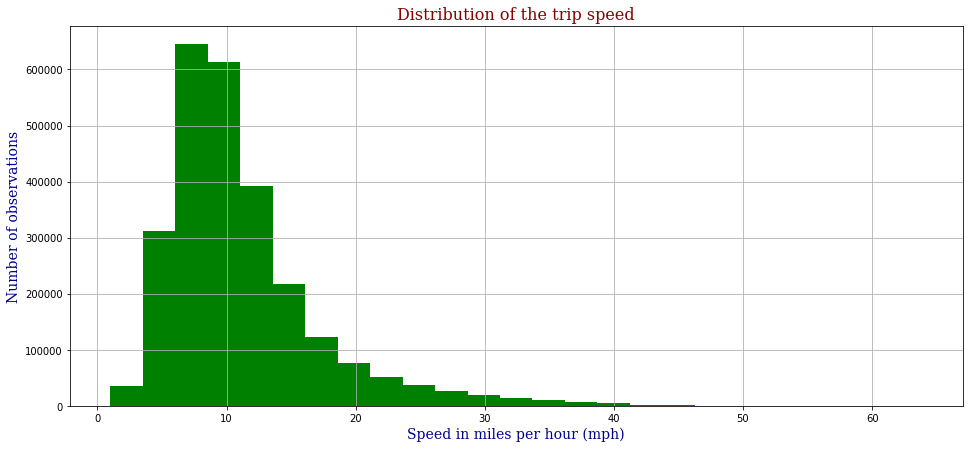

In [ ]:
df['trip_speed'].hist(bins=25 , color = 'green',figsize=(16,7) )
plt.title('Distribution of the trip speed',fontdict = {'family': 'serif',
                                                         'color':  'darkred',
                                                         'weight': 'normal',
                                                         'size': 16})

plt.ylabel('Number of observations' ,fontdict = {'family': 'serif',
                                                 'color' :  'darkblue',
                                                 'weight': 'normal',
                                                 'size'  : 14} )

plt.xlabel('Speed in miles per hour (mph)',fontdict = {'family': 'serif',
                                       'color' :  'darkblue',
                                       'weight': 'normal',
                                       'size'  : 14})

(Mikkel) We can from the above plot see that the distribution of trip speed is rather normally distributed with some tails for higher speeds. There might be some outliers in the higher trip speeds, but for now these are kept.

Plot done by Ali

Text(0.5, 0, 'Time in minutes')

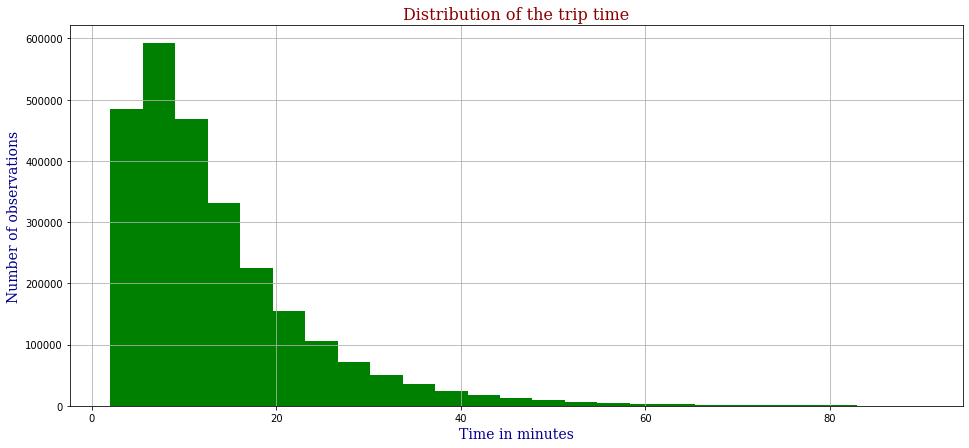

In [ ]:
df['trip_time_m'].hist(bins=25 , color = 'green',figsize=(16,7) )
plt.title('Distribution of the trip time',fontdict = {'family': 'serif',
                                                         'color':  'darkred',
                                                         'weight': 'normal',
                                                         'size': 16})

plt.ylabel('Number of observations' ,fontdict = {'family': 'serif',
                                                 'color' :  'darkblue',
                                                 'weight': 'normal',
                                                 'size'  : 14} )

plt.xlabel('Time in minutes',fontdict = {'family': 'serif',
                                       'color' :  'darkblue',
                                       'weight': 'normal',
                                       'size'  : 14})

(Mikkel) The trip duration in minutes also appears to follow a normal distribution, as the trip duration can't be less than zero this is of course bounded to the left. Clearly, most trips lasts about 10 minutes, which also could be expected when driving around in New York City often only are short trips. We see that some trips lasts up to 80 minutes and thereby being a fairly long trip when having in mind this is in New York City. 

Plot done by Ali

Text(0.5, 0, 'Amount in dollars')

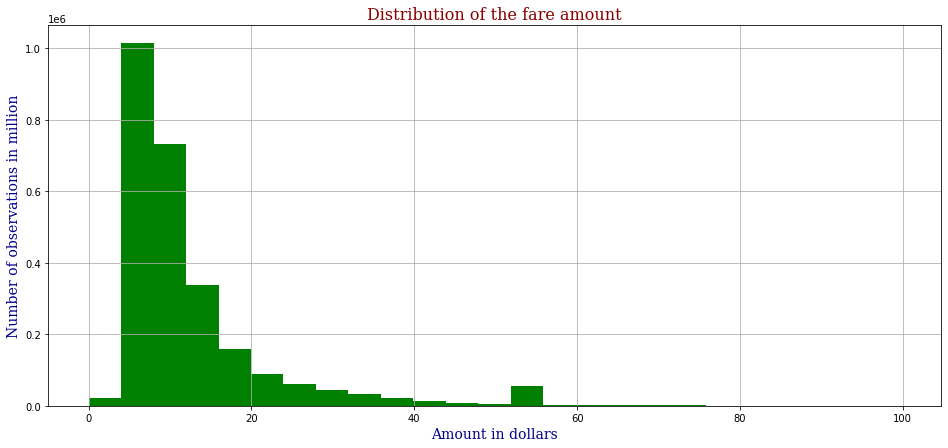

In [ ]:
df['fare_amount'].hist(bins=25 , color = 'green',figsize=(16,7))
plt.title('Distribution of the fare amount',fontdict = {'family': 'serif',
                                                         'color':  'darkred',
                                                         'weight': 'normal',
                                                         'size': 16})

plt.ylabel('Number of observations in million' ,fontdict = {'family': 'serif',
                                                 'color' :  'darkblue',
                                                 'weight': 'normal',
                                                 'size'  : 14} )

plt.xlabel('Amount in dollars',fontdict = {'family': 'serif',
                                       'color' :  'darkblue',
                                       'weight': 'normal',
                                       'size'  : 14})

(Mikkel) When looking at the distribution of the fare amount it is apparent that again this appear to be normal distributed and most of the trips taken are around 5-15 dollars. It should be noted that there are a peak around 50 dollars, which is the fixed price to JFK from Manhattan, and thereby we can see a lot are taking cabs to the airport.

Plot done by Ali

Text(0.5, 0, 'tip amount in dollars')

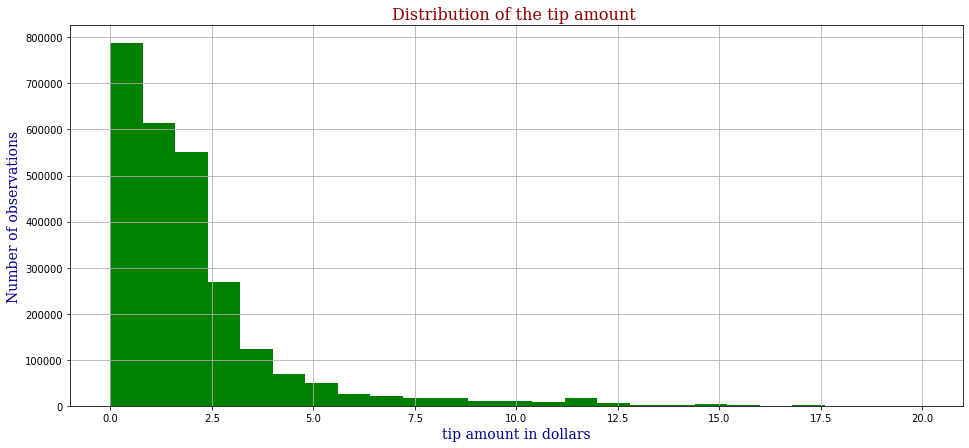

In [ ]:
df['tip_amount'].hist(bins=25 , color = 'green',figsize=(16,7))
plt.title('Distribution of the tip amount ',fontdict = {'family': 'serif',
                                                         'color':  'darkred',
                                                         'weight': 'normal',
                                                         'size': 16})

plt.ylabel('Number of observations' ,fontdict = {'family': 'serif',
                                                 'color' :  'darkblue',
                                                 'weight': 'normal',
                                                 'size'  : 14} )

plt.xlabel('tip amount in dollars',fontdict = {'family': 'serif',
                                       'color' :  'darkblue',
                                       'weight': 'normal',
                                       'size'  : 14})

(Mikkel) When looking at the distribution of the tip amount we can see that a lot of people are not tipping or only tipping a little. Most tips appears to be below 2.5 dollars. And again we see a little "peak" around 11 dollars which could be from the passengers going to the JFK airport. 

Plot done by Ali

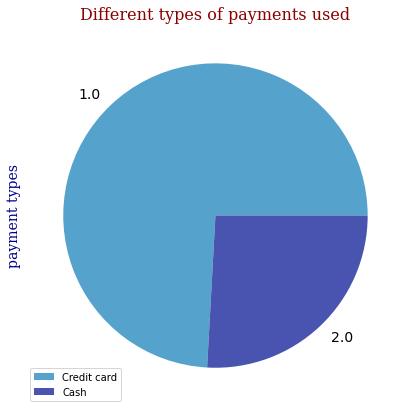

In [ ]:
df['payment_type'].value_counts().plot.pie(y='payment_type', figsize=(16, 7) , fontsize = 14, colors =sns.color_palette("icefire") )

plt.title('Different types of payments used',fontdict = {'family': 'serif',
                                                         'color':  'darkred',
                                                         'weight': 'normal',
                                                         'size': 16})

plt.ylabel('payment types' ,fontdict = {'family': 'serif',
                                        'color' :  'darkblue',
                                        'weight': 'normal',
                                        'size'  : 14} )

plt.legend( ['Credit card','Cash'])

(Mikkel) From this it is apparent that most passengers pay with credit card and only a quarter uses cash. 

Plot done by Ali

### Exploring the relationships between different features

Text(0.5, 0, 'Week days')

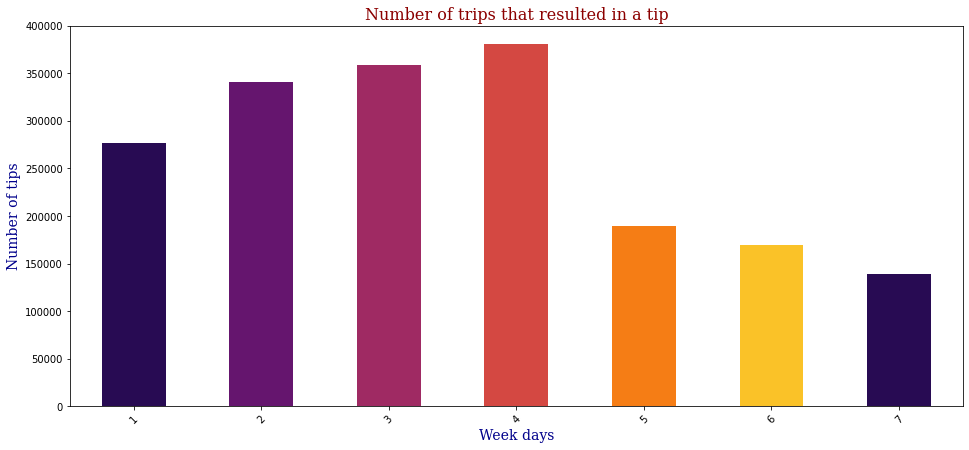

In [ ]:
df.groupby(['pu_weekday']).sum()['tipped'].plot(kind='bar',rot = 45,color=sns.color_palette("inferno"),figsize=(16,7))

plt.title('Number of trips that resulted in a tip',fontdict = {'family': 'serif',
                                                         'color':  'darkred',
                                                         'weight': 'normal',
                                                         'size': 16})

plt.ylabel('Number of tips' ,fontdict = {'family': 'serif',
                                                 'color' :  'darkblue',
                                                 'weight': 'normal',
                                                 'size'  : 14} )

plt.xlabel('Week days',fontdict = {'family': 'serif',
                                       'color' :  'darkblue',
                                       'weight': 'normal',
                                       'size'  : 14})

(Mikkel) When looking at what week days that most often result in a tip it is apparent that this is Thursdays, but one should take into account that these values should be normalized according to the number of trips. When looking at the next figure we can see how many trips that are taken on each weekday and it can be seen that most trips are taken on Thursdays and least on Sundays.

Plot done by Ali

Text(0.5, 0, 'Week days')

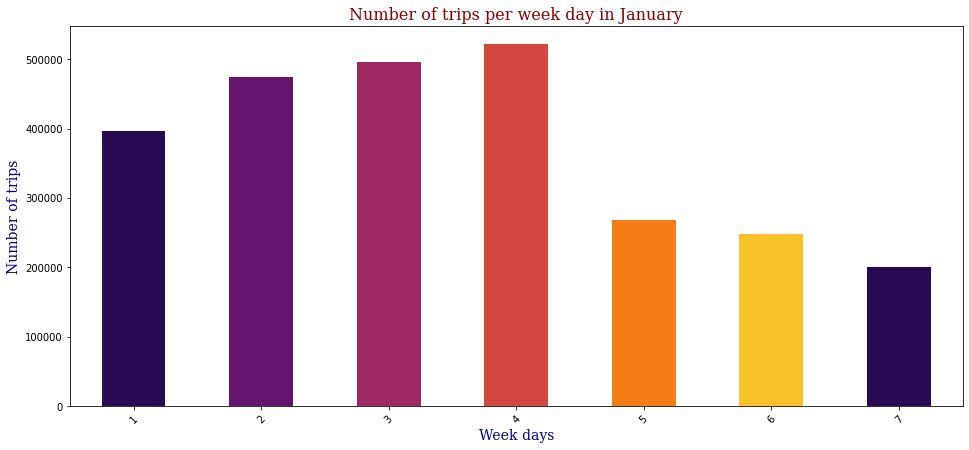

In [ ]:
df.groupby(['pu_weekday']).size().plot(kind='bar',rot = 45,color=sns.color_palette("inferno"),figsize=(16,7))

plt.title('Number of trips per week day in January',fontdict = {'family': 'serif',
                                                         'color':  'darkred',
                                                         'weight': 'normal',
                                                         'size': 16})

plt.ylabel('Number of trips' ,fontdict = {'family': 'serif',
                                                 'color' :  'darkblue',
                                                 'weight': 'normal',
                                                 'size'  : 14} )

plt.xlabel('Week days',fontdict = {'family': 'serif',
                                       'color' :  'darkblue',
                                       'weight': 'normal',
                                       'size'  : 14})


(Mikkel) We can observe that the amount of trips that result in a tip is proportional to the number of trips which is higher from monday to thursday compared to friday to sunday .

Plot done by Ali

Text(0.5, 0, 'Week days')

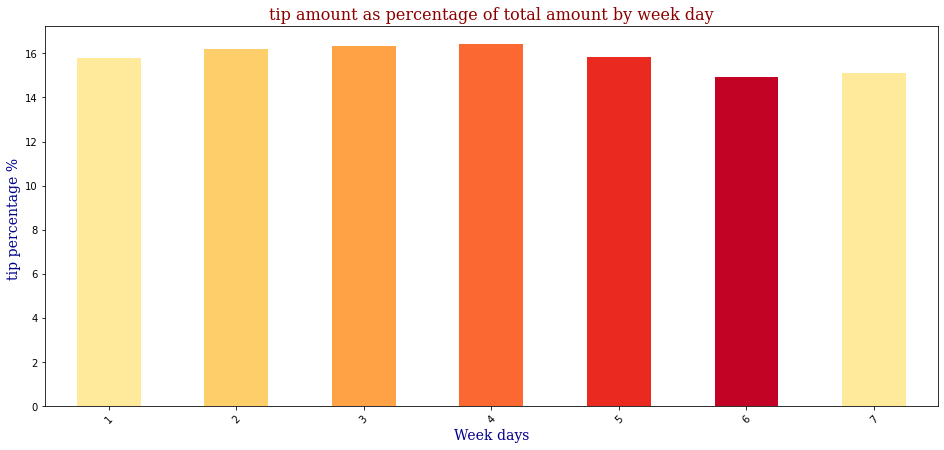

In [ ]:
df.groupby(['pu_weekday']).mean()['tip_pct'].plot(kind='bar',rot = 45,color=sns.color_palette("YlOrRd") ,figsize=(16,7))

plt.title('tip amount as percentage of total amount by week day',fontdict = {'family': 'serif',
                                                         'color':  'darkred',
                                                         'weight': 'normal',
                                                         'size': 16})

plt.ylabel('tip percentage % ' ,fontdict = {'family': 'serif',
                                                 'color' :  'darkblue',
                                                 'weight': 'normal',
                                                 'size'  : 14} )

plt.xlabel('Week days',fontdict = {'family': 'serif',
                                       'color' :  'darkblue',
                                       'weight': 'normal',
                                       'size'  : 14})


# we can observe that the tip percentage is very stable per day of week

(Mikkel) From this figure we can see that the tip percentage of the total amount appears to be rather constant across the week, with a little peak on Thursdays and a little bit lower on Saturdays. 

Plot done by Ali

Text(0.5, 0, 'pick up hour')

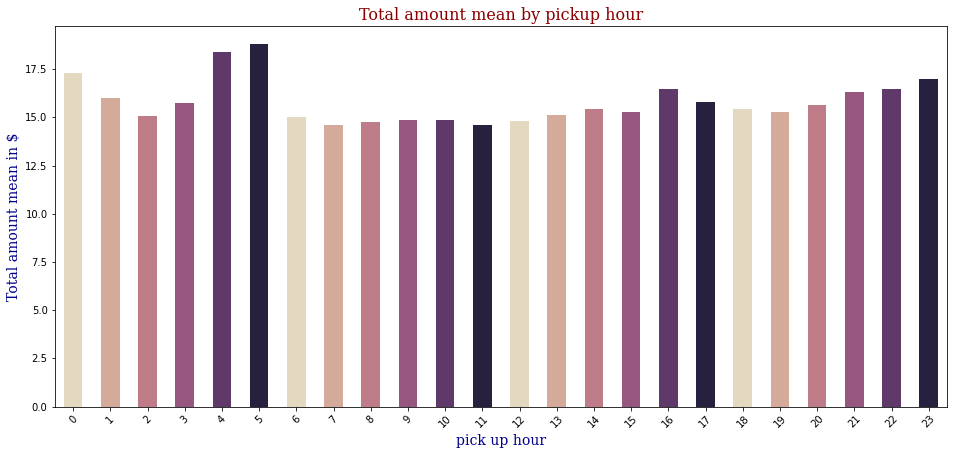

In [ ]:
#mean avg by hour
df.groupby(['pu_hour']).mean()['total_amount'].plot(kind = 'bar',rot = 45,color=sns.color_palette("ch:s=-.2,r=.6"),figsize=(16,7))


plt.title('Total amount mean by pickup hour',fontdict = {'family': 'serif',
                                                         'color':  'darkred',
                                                         'weight': 'normal',
                                                         'size': 16})

plt.ylabel('Total amount mean in $' ,fontdict = {'family': 'serif',
                                                 'color' :  'darkblue',
                                                 'weight': 'normal',
                                                 'size'  : 14} )

plt.xlabel('pick up hour',fontdict = {'family': 'serif',
                                       'color' :  'darkblue',
                                       'weight': 'normal',
                                       'size'  : 14})

(Mikkel) The figure above present the total amount as a function of the pickup hour. From this we can see that the total amount are highest in the early mornigns 4-5AM and substantially lower the rest of the day. It might be interesting to look into what the trip distance is for each of the pickup hours.

Plot done by Ali

Text(0.5, 0, 'pick up hour')

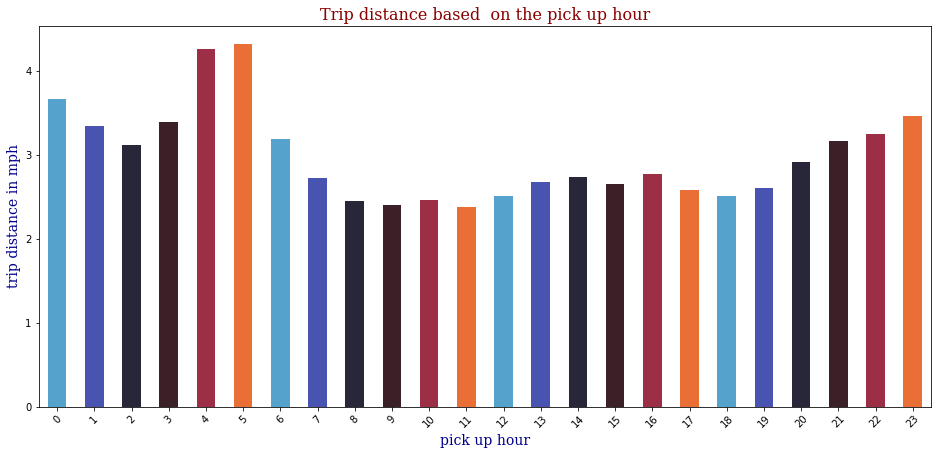

In [ ]:
df.groupby(['pu_hour']).mean()['trip_distance'].plot(kind = 'bar', rot = 45 , color = sns.color_palette("icefire"),figsize=(16,7))

plt.title('Trip distance based  on the pick up hour',fontdict = {'family': 'serif',
                                                              'color':  'darkred',
                                                              'weight': 'normal',
                                                              'size': 16})
plt.ylabel('trip distance in mph' ,fontdict = {'family': 'serif',
                                             'color' :  'darkblue',
                                             'weight': 'normal',
                                             'size'  : 14} )

plt.xlabel('pick up hour',fontdict = {'family': 'serif',
                                       'color' :  'darkblue',
                                       'weight': 'normal',
                                       'size'  : 14})

(Mikkel) When looking at the mean trip distance as a function of the pickup hour we can see that the early mornings 04-05 result in very long trips. This could be people going to the Airport to catch a flight or maybe people leaving for work which is far away. The long distance trips in the late evenings ie. from 20-00 could be people going home and don't want to drive themselves maybe do to alcohol consumption or being tired after a long day.

Plot done by Ali

Text(0.5, 0, 'pick up hour')

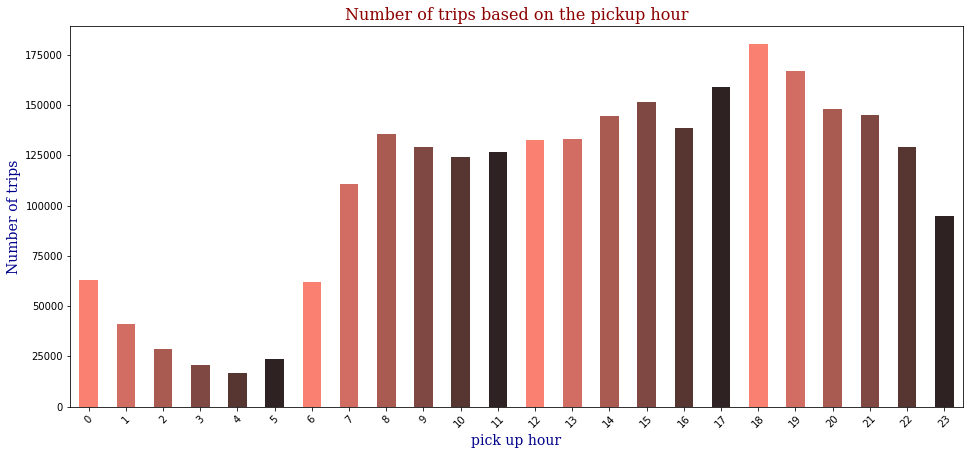

In [ ]:
# now i have to plot the number of trips per pickup hour
df.groupby(['pu_hour']).size().plot(kind = 'bar', rot = 45 , color = sns.color_palette("dark:salmon_r"),figsize=(16,7))

plt.title('Number of trips based on the pickup hour',fontdict = {'family': 'serif',
                                                              'color':  'darkred',
                                                              'weight': 'normal',
                                                              'size': 16})
plt.ylabel('Number of trips' ,fontdict = {'family': 'serif',
                                             'color' :  'darkblue',
                                             'weight': 'normal',
                                             'size'  : 14} )

plt.xlabel('pick up hour',fontdict = {'family': 'serif',
                                       'color' :  'darkblue',
                                       'weight': 'normal',
                                       'size'  : 14})

(Mikkel) We have looked into the number of trips pr. weekday and would also be interesting to look into this splitted into hourly format. From this we can see that the most popular pickup hour are 18 O'clock and the least is between 1-5. 

Plot done by Ali

Text(0.5, 0, 'pick up hour')

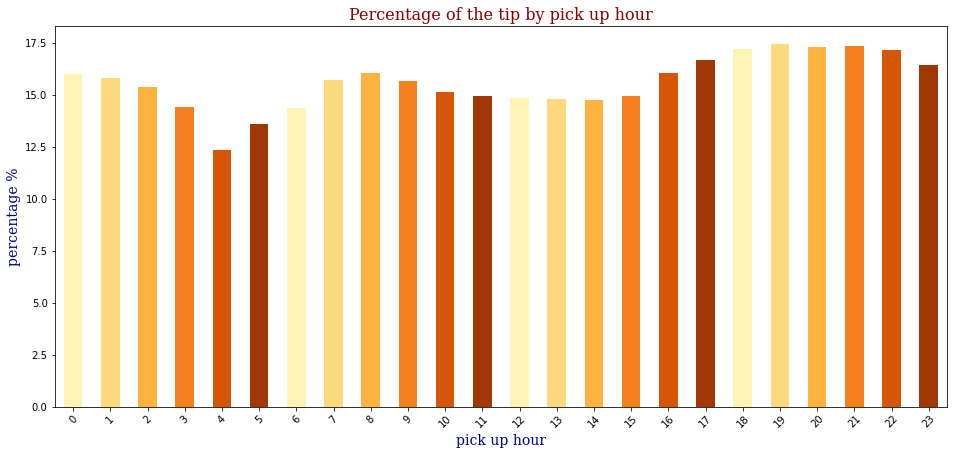

In [ ]:
#  percentage of the tip varying by the hour
df.groupby(['pu_hour']).mean()['tip_pct'].plot(kind = 'bar', rot = 45 , color = sns.color_palette("YlOrBr"),figsize=(16,7))

plt.title('Percentage of the tip by pick up hour',fontdict = {'family': 'serif',
                                                              'color':  'darkred',
                                                              'weight': 'normal',
                                                              'size': 16})
plt.ylabel('percentage %' ,fontdict = {'family': 'serif',
                                             'color' :  'darkblue',
                                             'weight': 'normal',
                                             'size'  : 14} )

plt.xlabel('pick up hour',fontdict = {'family': 'serif',
                                       'color' :  'darkblue',
                                       'weight': 'normal',
                                       'size'  : 14})


(Mikkel) Looking into not only what weekday that results in the highest tip but also which hour of the day. From this it can be seen that the long trips in the early mornings 4-5 does not result in high tip percentages. Whereas there appear to be a peak around 7-9, again from 18-22 and 0-2 where the tipping are a bit higher than the hours before and after.

Plot done by Ali

Text(0.5, 0, 'pick up hour')

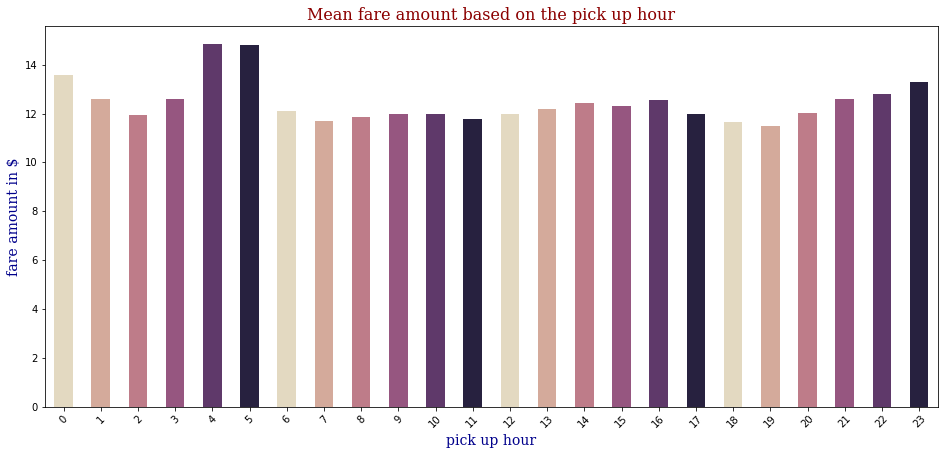

In [ ]:
df.groupby(['pu_hour']).mean()['fare_amount'].plot(kind = 'bar', rot = 45 , color = sns.color_palette("ch:s=-.2,r=.6"),figsize=(16,7) )

plt.title('Mean fare amount based on the pick up hour',fontdict = {'family': 'serif',
                                                                   'color':  'darkred',
                                                                   'weight': 'normal',
                                                                   'size': 16})
plt.ylabel('fare amount in $' ,fontdict = {'family': 'serif',
                                             'color' :  'darkblue',
                                             'weight': 'normal',
                                             'size'  : 14} )

plt.xlabel('pick up hour',fontdict = {'family': 'serif',
                                       'color' :  'darkblue',
                                       'weight': 'normal',
                                       'size'  : 14})

(Mikkel) When we look at the mean fare amount as a function of the pickup hour we can see that the fare amount are highest in the early mornings which matches the length of the trips and the total fareamount as expected. 

Plot done by Ali

Text(0.5, 0, 'pick up hour')

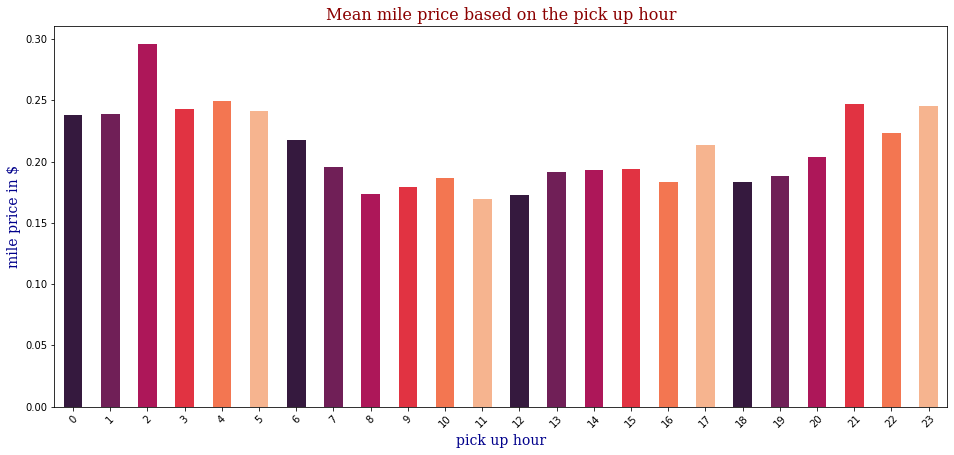

In [ ]:
# now i have to investigate if the price per miles varies based on the time of the day 
df['mile_price'] = df['trip_distance'] / df['fare_amount']

df.groupby(['pu_hour']).mean()['mile_price'].plot(kind = 'bar', rot = 45 , color = sns.color_palette("rocket") ,figsize=(16,7))
plt.title('Mean mile price based on the pick up hour' , fontdict = {'family': 'serif',
                                                                    'color':  'darkred',
                                                                    'weight': 'normal',
                                                                    'size': 16})
plt.ylabel('mile price in $' ,fontdict = {'family': 'serif',
                                          'color' :  'darkblue',
                                          'weight': 'normal',
                                          'size'  : 14})

plt.xlabel('pick up hour',fontdict = {'family': 'serif',
                                       'color' :  'darkblue',
                                       'weight': 'normal',
                                       'size'  : 14})

(Mikkel) Having looked at what pickup hours that results in high fare amounts, total amounts, tip percentages and what hours that are popular to use taxis. It could therefore also be interesting to see if some hours results in higher mile prices. From this we can see that trips at 2 results in high mean mile prices. Similarly, it can be seen that mean mile prices peaks at 17 and 21. The peak in mean mile price at 17 could be due to many people leaving work to go home and thereby resulting in waiting time due to traffic.

Plot done by Ali

Text(0.5, 0, 'Pick up hour')

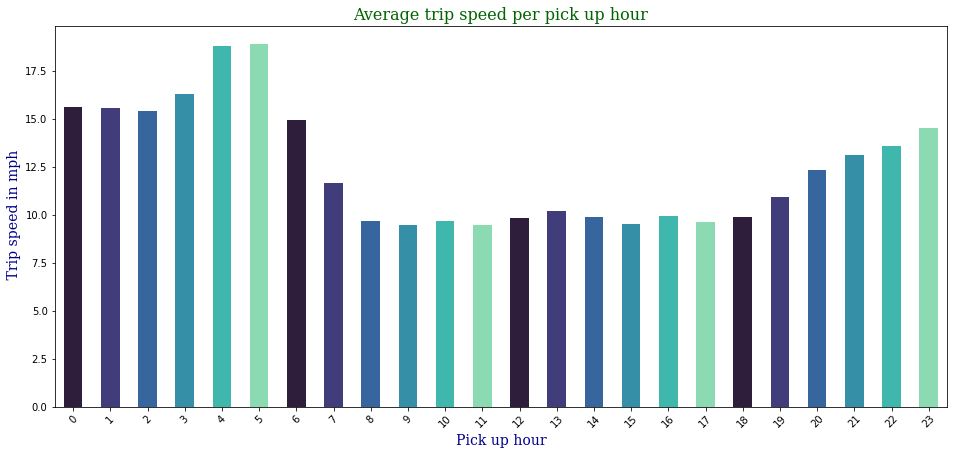

In [ ]:
# let s see if we can explain that high price based on the speed
df.groupby(['pu_hour']).mean()['trip_speed'].plot(kind = 'bar', rot = 45 , color =sns.color_palette("mako"),figsize=(16,7))
plt.title('Average trip speed per pick up hour',fontdict = {'family': 'serif',
                                                             'color':  'darkgreen',
                                                             'weight': 'normal',
                                                             'size': 16})
plt.ylabel(' Trip speed in mph' ,fontdict = {'family': 'serif',
                                             'color' :  'darkblue',
                                             'weight': 'normal',
                                             'size'  : 14} )

plt.xlabel('Pick up hour',fontdict = {'family': 'serif',
                                       'color' :  'darkblue',
                                       'weight': 'normal',
                                       'size'  : 14})

(Mikkel) There appeared to be some peaks in the previous plot, so investigating the trip speed would be interesting to see whether they just wait in the taxi due to traffic. We can clearly see that the trips around 17 drive very slow so the assumption of the high fare amount price pr mile might be due to this. The trip speed at 4-5 are very high and this could be due to little traffic. And we can see that the trip speed increases from 17 until 23 whereafter it appears to be more constant until 3 O'clock and then peaks 4-5 and decreases afterwards. 


Plot done by Ali

In [4]:
# Reload data to remove unnecessary features.

df = pd.read_pickle("2020_data.pkl")
df['duration'] = df['duration'].div(3600)
df['pickup_hour'] = df.tpep_pickup_datetime.dt.hour
df['dropoff_hour'] = df.tpep_dropoff_datetime.dt.hour
df['pickup_dayofweek'] = df.tpep_pickup_datetime.dt.weekday +1
df['dropoff_dayofweek'] = df.tpep_dropoff_datetime.dt.weekday+1
df['pickup_hourofweek'] = (df.pickup_dayofweek-1)*24  + df.pickup_hour.astype(int)+1
df['dropoff_hourofweek'] = (df.dropoff_dayofweek-1)*24  + df.dropoff_hour.astype(int)+1

df['PUborough'] = df['PULocationID'].map(borough_mapping)
df['DOborough'] = df['DOLocationID'].map(borough_mapping)

df['PUzone'] = df['PULocationID'].map(zone_mapping)
df['DOzone'] = df['DOLocationID'].map(zone_mapping)

df['pickup_month'] = df.tpep_pickup_datetime.dt.month
df['dropoff_month'] = df.tpep_dropoff_datetime.dt.month


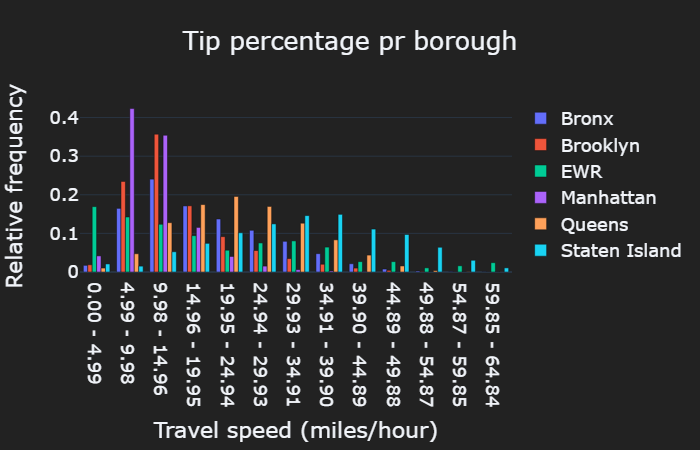

In [5]:
df['speed'] = df['trip_distance'].div(df['duration'])

boroughs = ['Manhattan', 'Queens', 'Staten Island','Brooklyn', 'Bronx']

layout = go.Layout(title='Tip percentage pr borough', xaxis_title = "Travel speed (miles/hour)", yaxis_title = "Relative frequency")
fig = go.Figure(layout=layout)

grp = df.groupby('PUborough')
end = 100
i = 0
for name, group in grp:
    hist = np.histogram(group.speed[(group.speed < 65) & (group.speed > 0)], bins = 13)
    
    if i == 0:
        # Adding labels to the chart
        labels = []
        for i, j in zip(hist[1][0::1], hist[1][1::1]):
            if j <= end:
                labels.append('{:.2f} - {:.2f}'.format(i, j))
            else:
                labels.append('> {}'.format(i))

    fig.add_trace(go.Bar(x = labels, y = hist[0]/len(group.speed[(group.speed < 100) & (group.speed > 0)]), name = name))
    i += 1
        
        
fig.update_layout(barmode='group',
              template="plotly_dark",
              title_x=0.5,
              plot_bgcolor = "#222",
              paper_bgcolor = "#222",
              font=dict(
                        size=18,
                    ),
              hoverlabel=dict(
                  font_size = 18)                   
                 )
#fig.write_html('images/speed_freq_borough.html')
fig.show()

##################################################### This code part are done by Mikkel ###################################################################

(Mikkel) This plot investigates the speed in each borough. From this it can be seen that there are a clear pattern in each borough. They all appear rather normal distributed.

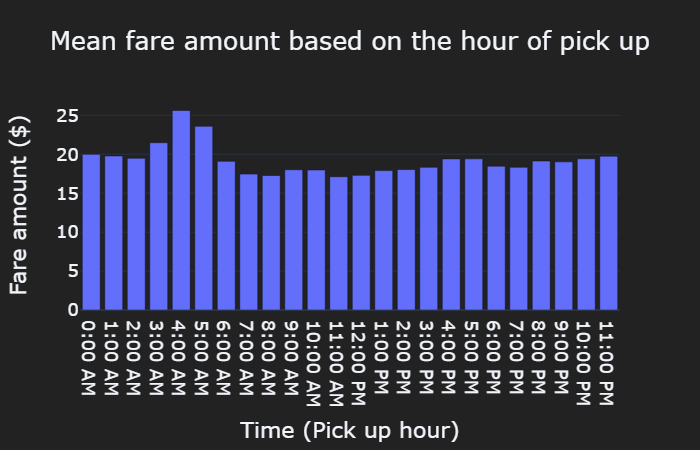

In [6]:
l_daily = [str(x) + ":00 " + str(y) for y in ['AM','PM'] for x in range(12)]
l_daily[12] = "12:00 PM"

total_amount_daily = df[df.total_amount>0].groupby('pickup_hour')['total_amount'].agg(total_amount ='mean')


layout = go.Layout(title='Mean fare amount based on the hour of pick up', xaxis_title = "Time (Pick up hour)", 
                   yaxis_title = "Fare amount ($) ")
fig = go.Figure(layout=layout)
fig.add_trace(go.Bar(x = l_daily, y = total_amount_daily.values.flatten()))
fig.update_layout(template="plotly_dark",
                  plot_bgcolor = "#222",
                  paper_bgcolor = "#222",
                  title_x=0.5,
                  font=dict(
                            size=18,
                        ),
                  hoverlabel=dict(
                      font_size = 18)                   
                 )
fig.show()
#fig.write_html('images/fare_amount_daily.html')
##################################################### This code part are done by Nicolai ###################################################################


(Nicolai) This plot shows the mean fare amount as a function of the hour of pick up. This figure is the same as the polar plot described in section 5, but only as a barplot instead. 

Text(0, 0.5, 'tip amount for cash payments')

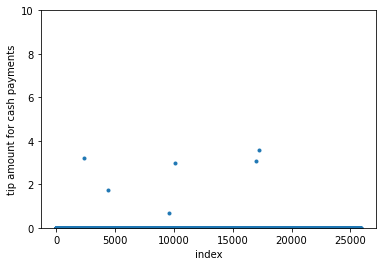

In [27]:
payment = df.loc[(df.payment_type.isin([1,2])) & (df.tip_amount >=0),['payment_type','tip_amount']].sample(n=100000, 
                                                                                                          random_state = 42,
                                                                                                          axis = 0)

credit = payment[payment.payment_type == 1].tip_amount.values
cash = payment[payment.payment_type == 2].tip_amount.values

plt.plot(cash, '.')
plt.ylim(0,10)
plt.xlabel('index')
plt.ylabel('tip amount for cash payments')

(Mikkel) When looking at the data we can see that almost none of the taxi drivers register tips when they are paid with cash and this would also make sense that this is not registered. This plot is included to show why further analysis different payment types are not done.

**Write a short section that discusses the dataset stats, containing key points/plots from your exploratory data analysis.** 


(Ali) The longest trips are the ones that are taken by people between 4 and 5 am probably people that have to work far form where they live, and based on the data that we have those people leave the smallest tip as a percentage of the trip, even though they have the longest trips.<br>
Interestingly the price per miles varies and it is at the highest level at 2 am.<br>
The fare amount is highest between 4 to 6 am we can explain that since the TLC charges an additional amount based on the speed of the trip, but it does not expain why trips between 4 and 5 am have a cheaper rate than between  and 5 and 6  am.<br>
The highest tip percentage is the one paid on the trips between  5 and 10 pm peaking at around 17 percent of the total fare amount.

### Geo data visualization

The code below are used for formatting the data for both the colorbar but also when hovering the zones on the map.

(Mikkel)The *geo_zone_no_dropoff.geojson* file can be found on the [github](https://github.com/MikkelMathiasen23/NYC_taxi_project/tree/main/preprocessed_data) and the [script](https://github.com/MikkelMathiasen23/NYC_taxi_project/blob/main/data_preprocessing.py) generating can as well. The script loads the data from TLC and the shape data, and afterwards the pickup and dropoff locations are mapped to the shapefiles. Afterwards the tip, fareamount, pickups and tip percentage are calculated for each zone and for each hour of the day. Afterwards this i saved in the geojson file format needed for the bokeh plotting.

In [7]:
geo = gpd.read_file('preprocessed_data/geo_zone_no_dropoff.geojson')

format_data = [('tip_p', np.quantile(geo.tip_p, 0.05), np.quantile(geo.tip_p, 0.95),'0%', 'Tip percentage'),
               ('tip_amount', 0, np.quantile(geo.tip_amount, 0.95),'$0,0', 'Average Tip amount'),
               ('fare_amount', 0, np.quantile(geo.fare_amount, 0.95), '$0,0', 'Average fare amount'),
               ('pickup', 0, np.quantile(geo.pickup, 0.8),'0,0', 'Amount of pickups'),
               #('dropoff', 0, np.quantile(geo.dropoff,0.95),'0,0', 'Amount of dropoffs'),
              ]

#Create a DataFrame object from the dictionary 
format_df = pd.DataFrame(format_data, columns = ['field' , 'min_range', 'max_range' , 'format', 'verbage'])

(Mikkel) As the visualization are done interactive the code below are done to make the figure update when the slider are used. The slider are used so the user can slide through the hours of the day. Each zone are coloured according to the selected criteri by the user. The user can select: average tip amount, average fare amount, the tip percentage of the total amount and number of pickups in each zone. 

A logaritmic colorbar are chosen due to huge difference between the zones, and by using this all zones are coloured so it is easy to see the respective change in each zone. 

In [8]:
#
# Plotting functions

def json_data(selectedHour):
    M = selectedHour
    
    # Pull selected year from neighborhood summary data
    df_M = geo[geo['hour'] == M]
    
     # Merge the GeoDataframe object (sf) with the neighborhood summary data (neighborhood)
    merged =df_M
    # Fill the null values
    values = {'Hour': M, 'tip_p': 0, 'tip_amount': 0, 'fare_amount': 0, 'pickup':0, 'dropoff':0}
    merged = merged.fillna(value=values)
    
    # Bokeh uses geojson formatting, representing geographical features, with json
    # Convert to json
    merged_json = json.loads(merged.to_json())
    
    # Convert to json preferred string-like object 
    json_data = json.dumps(merged_json)
    return json_data, df_M

# Define the callback function: update_plot
def update_plot(attr, old, new):
    # The input hour is the hour selected from the slider
    M = slider.value
    new_data, df_M = json_data(M)
    
    # The input cr is the criteria selected from the select box
    cr = select.value
    input_field = format_df.loc[format_df['verbage'] == cr, 'field'].iloc[0]
    
    # Update the plot based on the changed inputs
    p = make_plot(input_field, df_M)
    
    # Update the layout, clear the old document and display the new document
    layout = column(p, widgetbox(select), widgetbox(slider))
    curdoc().clear()
    curdoc().add_root(layout)
    
    # Update the data
    geosource.geojson = new_data 
    
# Create a plotting function
def make_plot(field_name, new_data):    
    # Set the format of the colorbar
    #min_range = format_df.loc[format_df['field'] == field_name, 'min_range'].iloc[0]
    #max_range = format_df.loc[format_df['field'] == field_name, 'max_range'].iloc[0]
    min_range = np.quantile(new_data[field_name], 0.05)
    max_range = np.quantile(new_data[field_name], 0.95)
    field_format = format_df.loc[format_df['field'] == field_name, 'format'].iloc[0]

    # Instantiate LinearColorMapper that linearly maps numbers in a range, into a sequence of colors.
    color_mapper = LogColorMapper(palette = palette, low = min_range, high = max_range)

    # Create color bar.
    format_tick = NumeralTickFormatter(format=field_format)
    color_bar = ColorBar(color_mapper=color_mapper, label_standoff=18, formatter=format_tick,
    border_line_color=None, location = (0, 0))

    # Create figure object.
    verbage = format_df.loc[format_df['field'] == field_name, 'verbage'].iloc[0]

    p = figure(title = verbage + ' - NYC in 2020',
               title_location = "above", 
             plot_height = 900, plot_width = 900,
             toolbar_location = None)
    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None
    p.axis.visible = False

    # Add patch renderer to figure. 
    p.patches('xs','ys', source = geosource, fill_color = {'field' : field_name, 'transform' : color_mapper},
          line_color = 'black', line_width = 0.25, fill_alpha = 1)

    # Specify color bar layout.
    p.add_layout(color_bar, 'right')


    tile_provider = get_provider(STAMEN_TONER)
    p.add_tile(tile_provider)

    # Add the hover tool to the graph
    p.add_tools(hover)
    return p


A static version of the image are shown below. 

**Note: Make this notebook trusted in order to view the geomap plot.**

In [9]:
# Creating interactive map plot

# Input geojson source that contains features for plotting for:
geosource = GeoJSONDataSource(geojson = json_data(0)[0])
input_field = 'pickup'

# Define a sequential multi-hue color palette.
palette = Plasma[8]

# Reverse color order so that dark blue is highest obesity.
palette = palette[::-1]

# Add hover tool
hover = HoverTool(tooltips = [ ('Zone','@zone'),
                               ('Borough','@borough'),
                               ('Tip percentage', '@tip_p{0%}'),
                               ('Average Tip amount', '$@tip_amount{,}'),
                               ('Average fare amount', '$@fare_amount{,}'),
                               ('Amount of pickups', '@pickup{,}'),
                               #('Amount of dropoffs', '@dropoff{,}')
                               ]
)

# Call the plotting function
p = make_plot(input_field, json_data(0)[1])

tile_provider = get_provider(STAMEN_TONER)
p.add_tile(tile_provider)

# Make a slider object: slider 
slider = Slider(title = 'Hour',start = 0, end = 23, step = 1, value = 1)
slider.on_change('value', update_plot)

# Make a selection object: select
select = Select(title='Select Criteria:', value='Amount of pickups', options=['Tip percentage', 'Average Tip amount',
                                                                               'Average fare amount', 'Amount of pickups', #'Amount of dropoffs'
                                                                               ])
select.on_change('value', update_plot)

# Make a column layout of widgetbox(slider) and plot, and add it to the current document
# Display the current document
layout = column(p, widgetbox(select), widgetbox(slider))
curdoc().add_root(layout)
curdoc().theme = 'dark_minimal'

p.background_fill_color = "#222"

# Use the following code to test in a notebook
# Interactive features will no show in notebook

output_notebook()
show(p)

#output_file('images/frontpage_plot.html')
#save(p)


#The code used for setting up this figure are taken and slightly modified from: https://github.com/JimKing100/SF_Real_Estate_Live/blob/master/SF_Map_Code_Final.ipynb 

Loading BokehJS ...

<h1 align="center"> 3. Data Analysis </h1> 

**Describe your data analysis and explain what you've learned about the dataset.** (Nicolai)
Through the data analysis, it has been tried to establish what the most important factors are for earning more/recieving a higher tip for taxi driver. This has been done by exploring the temporal and spatial features of the data set while looking for patterns or indicators of higher fare amount and tips. Through this, we have learned that it appears the best tipping boroughs of New York City are Manhatten and Queens while Staten Island tends to give lower tips. It is also apparent, that most taxi trips are within the Manhatten area. When considering the temporal features of the data set, tips are best during the evening through the night, i.e. 8 pm - 3 am for Monday through Friday. Tips are most constant for the hours of the weekend. If tipping behaviour for only weekdays is considered, then Monday and Sunday are the best days to work for the most tips per hour. It has also been learned that the amount of passengers does not affect the tip amount. 

**If relevant, talk about your machine-learning.**(Ali)

Before applying machine learning algorithms we have to do feature engineering , the first thing that we will do is to do a one hot encoding for categorical variables such as the  pick up / drop off borough, the pick up / drop off zone, the vendor ID , and the Rate code ID.<br>

The second thing will be to have a cyclical endoding of the time data using the sine and cosine function in order to capture the cyclical nature of time (23 is close to 0, day 1 is close to day 7 ).<br>
Then we are going to divide our dataset into the feature matrix that will be used for the prediction, and the taget variable ('tipped' for classification and *tip_amount* for regression) in order to evaluate our model we are going to use hold out cross validation with 70 percent for training and 30 percent for testing.
Then we are going to assess the model using different metrics such the auc and R-square for the regression model . 


In [ ]:
# one hot encoding for categorical data
binpub = pd.get_dummies(df['PUborough'], prefix = 'pub')
bindob = pd.get_dummies(df['DOborough'], prefix = 'dob')
binpuz = pd.get_dummies(df['PUzone'], prefix = 'puz')
bindoz = pd.get_dummies(df['DOzone'], prefix = 'doz')

binven = pd.get_dummies(df['VendorID'], prefix = 'ven')
binrate = pd.get_dummies(df['RatecodeID'], prefix = 'rc')
# cyclical encoding for the temporal features

df['sin_up_hour'] = np.sin(df.pu_hour*(2.*np.pi/24))
df['cos_up_hour'] = np.cos(df.pu_hour*(2.*np.pi/24))

df['sin_do_hour'] = np.sin(df.do_hour*(2.*np.pi/24))
df['cos_do_hour'] = np.cos(df.do_hour*(2.*np.pi/24))

# let s write the new features what i m waiting for 
df['sin_up_day'] = np.sin(df.pu_weekday*(2.*np.pi/7))
df['cos_up_day'] = np.cos(df.pu_weekday*(2.*np.pi/7))

df['sin_do_day'] = np.sin(df.do_weekday*(2.*np.pi/7))
df['cos_do_day'] = np.cos(df.do_weekday*(2.*np.pi/7))

### Predicting if a passenger will tip
(Mikkel)
Firstly, it would be predicted whether a passenger will tip or not, thereby making it a binary classification problem. The selected method for this are a Random Forest classification tree, as these have proved to be robust against overfitting. Random Forest has as well shown to be very flexible and thereby can be used for difficult tasks! 
A random selection of samples are selected as the data amount otherwise would make the computation very lengthy. The data are split into train and test, so the model performance can be evaluated on a separate test set. This makes it possible to test how well the model generalizes to new unseen data. The used input features can be seen further down when looking at the feature importance.

In [ ]:
# preparing the feature matrix and target value for classification
df_clf = pd.concat([df,binven,binrate,binpub,bindob], axis=1)


# we are only going to predict for credit card payment
df_clf['payment_type'] = df[df['payment_type'] == 1.0]['payment_type']

# drop the tip amount but leave the tipped value in order to be used 
df_clf = df_clf.drop(['VendorID','tpep_pickup_datetime', 'tpep_dropoff_datetime', 'RatecodeID','store_and_fwd_flag','mile_price','pickup_hourofweek',
                          'payment_type','trip_time','trip_time_h','pu_weekday','do_weekday','PUborough','DOborough','PUzone','DOzone','dropoff_hourofweek',
                         'pu_hour','do_hour','mta_tax','month','improvement_surcharge','congestion_surcharge','tip_pct','total_amount','tip_amount'], axis=1)

##################################################### CODE BY ALI #####################################################

In [ ]:
# our classification will operate on a million rows
df_clf= df_clf.sample(n=1000000, random_state=42)

y1 = df_clf['tipped']

# the feature matrix
x1 = df_clf.drop(['tipped'], axis=1)

# hold out cross validation
x_train, x_test, y_train, y_test = train_test_split(x1,y1, test_size=0.30, random_state=42)

##################################################### CODE BY ALI #####################################################

In [ ]:
# loading the model that we trained previously
path = r'drive/MyDrive/models/model1.sav'
file = open(path, 'rb')
model1 = pickle.load(file)
file.close()
##################################################### CODE BY ALI #####################################################

In [ ]:
model1 = RandomForestClassifier(n_jobs=-1,random_state= 42)

# training the model
model1.fit(x_train, y_train)
##################################################### CODE BY ALI #####################################################

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [ ]:
pred1 = model1.predict(x_test)
##################################################### CODE BY ALI #####################################################


In [ ]:
model1.score(x_test,y_test)
##################################################### CODE BY ALI #####################################################

0.7143733333333333

In [ ]:
# the accuracy of the prediction
accuracym1 = accuracy_score(pred1,y_test)

# the confusion matrix
cf_mat_m1 = pd.DataFrame(confusion_matrix(y_test, pred1))

# the classification report
clfreport = classification_report(y_test,pred1,output_dict=True)

# storing the classification report in a data frame
clf_report_m1 = pd.DataFrame(clfreport).transpose().sort_values(by=['f1-score'], ascending=False)
##################################################### CODE BY ALI #####################################################

Text(0.5, 1.0, 'Confusion matrix for the Random forest clasifer')

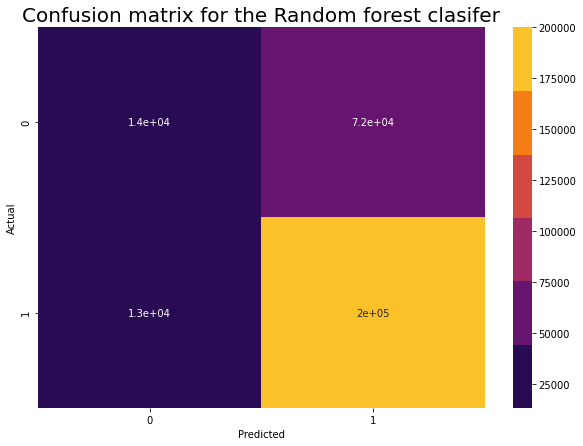

In [ ]:
# displaying the confusion matrix
cf_mat_m1.index.name = 'Actual'
cf_mat_m1.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
#"Blues"
sns.heatmap(cf_mat_m1, cmap= sns.color_palette("inferno") , annot=True )
plt.title("Confusion matrix for the Random forest clasifer",fontsize=20)
##################################################### CODE BY ALI #####################################################


(Mikkel) From this it is apparent that the model does predict the majority of people that are tipping, whereas it appears to be more difficult for the model to predict if a passenger does not tip. And appears as the model are prone to predicting that a person does tip, which might also be the case as the majority of the passengers does leave a tip, thereby making the classification problem unbalanced. When looking at the accuracy the model gets a score of 0.71, but when looking at the F1-score this results in 0.66. The F1-score are a good metric when operating with unbalanced datasets.

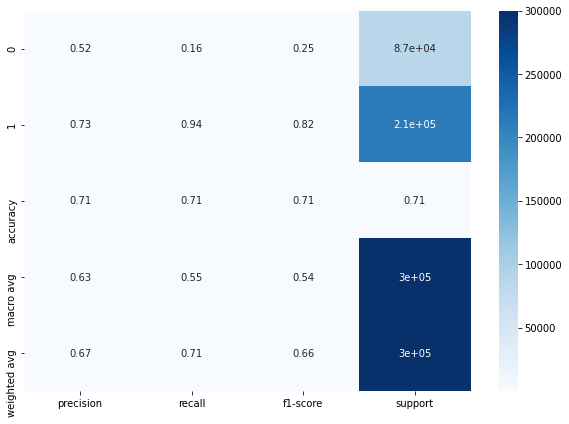

In [ ]:
# displaying a heatmap of the classification report
plt.figure(figsize = (10,7))
sns.heatmap(clf_report_m1.sort_index(), cmap= "Blues", annot=True,)
##################################################### CODE BY ALI #####################################################

(Mikkel) It would further be interesting to investigate which features that the model defines as the most important features, as this would tell us what features that could be determining whether a person will or not. The most important appears to be *trip_speed*, *trip_time_m*, *trip_distance*, *DOLocationID*, *PULocationID*, *fare_amount* and *passenger_count*, but clearly the trip speed, duration, distance and the location for the pickup and dropoff appears to be the most important. This would also make sense since some neighbourhoods might be more wealthy and maybe more prone to tipping. Also the distance and time would make more time for the passenger and driver to get to know each other which probably could result in tips. Further, the trip speed might be a bad thing, as a driver just racing through town would not result in a very happy passenger, unless the passenger asks for it. 

In [ ]:
# generating the feature importance for the random forest

features = x1.keys().to_list()

importance = list(zip(features, model1.feature_importances_))

importance.sort(key=lambda x: -x[1])

imp_m1 = pd.DataFrame(importance, columns=["Feature","Importance"] )
#imp_m1 = pd.DataFrame(importance, index = features)

#imp_m1[:10].plot(kind='bar',rot = 45 ,ylabel= "feature importance" ,xlabel = "features" ,title ="feature importance for the random forest")
imp_m1
##################################################### CODE BY ALI #####################################################


Feature  Importance
0          trip_speed    0.156738
1         trip_time_m    0.152910
2       trip_distance    0.127753
3        DOLocationID    0.114743
4        PULocationID    0.112547
5         fare_amount    0.080350
6     passenger_count    0.029787
7         sin_do_hour    0.027862
8         sin_up_hour    0.027495
9         cos_do_hour    0.026317
10        cos_up_hour    0.026090
11         sin_up_day    0.015955
12         sin_do_day    0.015919
13         cos_do_day    0.012193
14         cos_up_day    0.012138
15            ven_2.0    0.011573
16            ven_1.0    0.011556
17              extra    0.006351
18             rc_5.0    0.005742
19          dob_Bronx    0.003946
20      dob_Manhattan    0.003687
21      pub_Manhattan    0.002939
22         dob_Queens    0.002736
23       tolls_amount    0.002467
24         pub_Queens    0.002410
25       pub_Brooklyn    0.001887
26       dob_Brooklyn    0.001657
27          pub_Bronx    0.001518
28             rc_1.0    0.001003
29            ven_4.0    0.000938
30             rc_2.0    0.000502
31            dob_EWR    0.000086
32             rc_3.0    0.000079
33             rc_4.0    0.000068
34  dob_Staten Island    0.000048
35  pub_Staten Island    0.000009
36            pub_EWR    0.000001
37             rc_6.0    0.000000

Text(0.5, 0, 'Features')

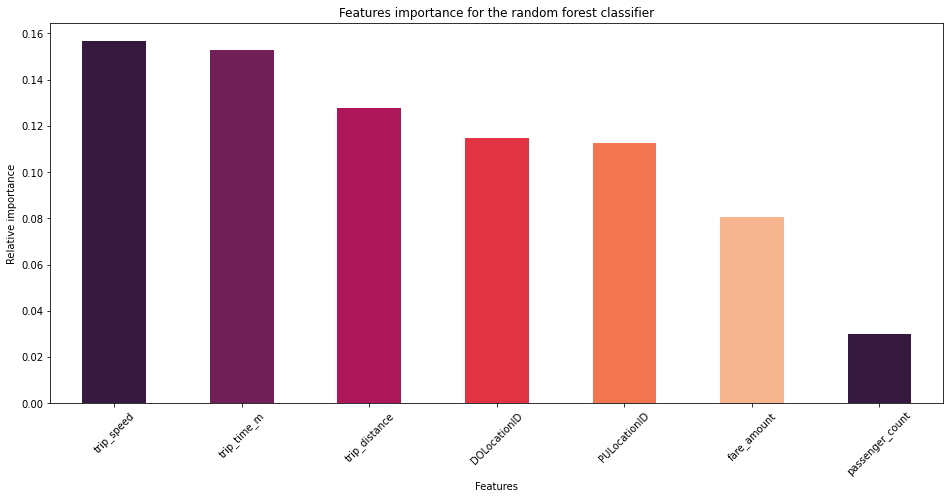

In [ ]:
feat_importances = pd.Series(model1.feature_importances_ , index=x1.columns)
feat_importances.nlargest(7).plot(kind='bar',rot = 45 , color = sns.color_palette("rocket") ,figsize=(16,7))
plt.title("Features importance for the random forest classifier")
plt.ylabel("Relative importance")
plt.xlabel("Features")
##################################################### CODE BY ALI #####################################################

In [ ]:
roc_auc_score(y_test, model1.predict_proba(x_test)[:,1])
##################################################### CODE BY ALI #####################################################

0.6128482912133656

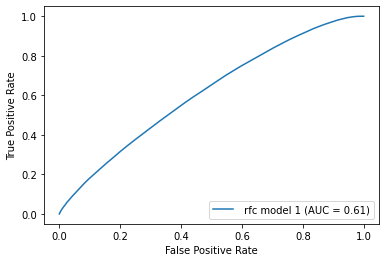

In [ ]:

# now we have to plot the roc curve
metrics.plot_roc_curve(model1, x_test, y_test,name=" rfc model 1") 
##################################################### CODE BY ALI #####################################################

(Mikkel) The AUC can be used to determine if the model are better than random guessing and from the compute AUC score of 0.61 this indicates that the model are better than random guessing. Also when looking at the ROC plot we can see that the model are slightly better than random guessing. So there are definitely room for improvement. 

### Predicting the amount of the tip

(Mikkel) It is now wished to predict the tip amount thereby making it a regression problem. Random Forest are again utilized for this task using a Random Forest regression tree. Almost the same input features are used as before. The data are again split into train and test and a random selection of rows are used as it otherwise would have taken to long time to compute. 

In [ ]:
# we include the new encoded variables
df_train = pd.concat([df,binven,binrate], axis=1).sample(n=1000000, random_state=42)


# the tipping is only available for the one in credit card
df_train['payment_type'] = df[df['payment_type'] == 1.0]['payment_type']


# dropping the features that will not be used in the model
df_train = df_train.drop(['VendorID','tpep_pickup_datetime', 'tpep_dropoff_datetime', 'RatecodeID','store_and_fwd_flag',
                          'payment_type','trip_time','trip_time_h','pu_weekday','do_weekday','PUborough','DOborough','PUzone','DOzone',
                         'pu_hour','do_hour','mta_tax','month','improvement_surcharge','congestion_surcharge','tip_pct','total_amount','tipped'], axis=1)

##################################################### CODE BY ALI #####################################################

In [ ]:
# the target variable
y2 = df_train['tip_amount'].tolist()

# the feature matrix
x2 = df_train.drop(['tip_amount'], axis=1)
sc = StandardScaler()
x2 = sc.fit_transform(x2)

# hold out cross validation
x_train2, x_test2, y_train2, y_test2 = train_test_split(x2,y2, test_size=0.30, random_state=42)
##################################################### CODE BY ALI #####################################################

In [ ]:
# we instanciate the model
model = LinearRegression()

# we train the model


model.fit(x_train2, y_train2)
##################################################### CODE BY ALI #####################################################

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
pred2 = model.predict(x_test2)
##################################################### CODE BY ALI #####################################################

In [ ]:
r2_score(y_test2, pred2)
##################################################### CODE BY ALI #####################################################

0.4328603737269543

In [ ]:
with open(r'drive/MyDrive/models/model1.sav', 'wb') as fid:
     pickle.dump(model1, fid)
##################################################### CODE BY ALI #####################################################

In [ ]:
with open(r'drive/MyDrive/models/regmodel.sav', 'wb') as fid2:
     pickle.dump(model, fid2)
##################################################### CODE BY ALI #####################################################

In [ ]:
# now it s time for the random forest regressor 
model3= RandomForestRegressor(n_jobs=-1,random_state=42)
# we train the model
model3.fit(x_train2, y_train2)
##################################################### CODE BY ALI #####################################################

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [ ]:
pred3 = model3.predict(x_test2)
##################################################### CODE BY ALI #####################################################

In [ ]:
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test2, pred3))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(y_test2, pred3))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_test2, pred3)))
##################################################### CODE BY ALI #####################################################


Mean Absolute Error (MAE): 1.1251532544126983
Mean Squared Error (MSE): 2.6992205200912407
Root Mean Squared Error (RMSE): 1.6429304672113305


In [ ]:
r2_score(y_test2, pred3)
##################################################### CODE BY ALI #####################################################

0.4569636156261394

(Mikkel) The resulting model has a R-squared value of 0.45 thereby not having a very strong correlation with the actual result. There are room for improvement. Also the hyperparameters of the Random Forest could have been tuned, but due to the large amount of data, this would result in heavy computation load. 

<h1 align="center"> 4. Genre. Which genre of data story did you use? </h1> 


(Nicolai) We have chosen a slide-show as our narration tool for the story. This corresponds to a linear narrative structure but we have also included some elements of user directed path. This is expanded on in the **Narrative Structure** section. 

**Which tools did you use from each of the 3 categories of Visual Narrative (Figure 7 in Segal and Heer). Why?**(Nicolai)
- *Consistent visual platform*: We have tried to keep the theme and the visualisations consistent throughout the website in order to make it easier for the user to orient and navigate. This is done by using the same color theme for the website background and visualisation background while keeping the overall structure of the website consistent throughout the slides.
- *Progress bar*: A progress bar has been added to the website in order to help the user get an overview of how "far" into the story they have progressed.
- *Feature Distinction*: While the color scheme of the visualisations have been kept consistent to keep a *consistent visual platform*, the colors have also been used to highlight key features of a visualisations. Additionally, they have also been used to help the user distinguish between features in the visualisations. 
- *Motion/Animated Transitions*: A motion/transition has been used when switching slides in order to switch focus in the narration while the user navigate the story.  

**Which tools did you use from each of the 3 categories of Narrative Structure (Figure 7 in Segal and Heer). Why?**(Mikkel)
- *User Directed Path/Linear*: The website follows the structure of the first vertical slides asking a key question regarding taxi driving in New York City. While there is a distinctively linear ordering of the website, the user can also navigate further vertically in order to read further about answers to the first key question. This both linear but also user defined path helps keep the user engaged while keeping the path of the narrative.
- *Hover Highlighting/Details*: All figures on the website have interactive hover tooltips. This helps convey more information to the curious reader.
- *Filtering / Selection*: All the visualisations containing legends can be filtered by interacting with the legend. This way, the user can filter for features to investigate the underlaying data further if it has peeked their interest. This can also be used to select a subset of the displayed data if this is wished. Additionally, for the interactive map of New York City a slider for the time of day and selected criterions can be selected/filtered as wished. This helps the user find their own key take aways while keeping the user engaged.
- *Summary*: For each key question asked, a partial conclusion has been written that summarizes the previous vertical slides. This is included in order to guide the user's exploration of the data. 




<h1 align="center"> 5. Visualizations. </h1> 

**Explain the visualizations you've chosen.**
**Why are they right for the story you want to tell?**

These two questions are answered below each figure, this is done to make it more easy to follow the idea. 


The following code are just for setting up stuff for the plotting.

In [10]:
col_mapping = {'MON': 'mediumvioletred',
                'TUE': 'orangered',
                'WED': 'springgreen',
                'THU': 'lightseagreen',
                'FRI': 'orange',
                'SAT': 'aqua',
                'SUN': 'crimson'}

dayofweek_mapping = {'1': 'MON',
                     '2': 'TUE',
                     '3': 'WED',
                     '4': 'THU',
                     '5': 'FRI',
                     '6': 'SAT',
                     '7': 'SUN'}

l = ["MON " + str(x) + ":00 " + str(y) for y in ['AM','PM'] for x in range(12) ]
l.extend(["TUE " + str(x)+ ":00 " + str(y) for y in ['AM','PM'] for x in range(12) ])
l.extend(["WED " + str(x)+ ":00 "+ str(y) for y in ['AM','PM'] for x in range(12) ])
l.extend(["THU " + str(x)+ ":00 " + str(y) for y in ['AM','PM'] for x in range(12) ])
l.extend(["FRI " + str(x)+ ":00 " + str(y) for y in ['AM','PM'] for x in range(12) ])
l.extend(["SAT " + str(x)+ ":00 " + str(y) for y in ['AM','PM'] for x in range(12) ])
l.extend(["SUN " + str(x)+ ":00 " + str(y) for y in ['AM','PM'] for x in range(12) ])

l[12] = 'MON 12:00 PM'
l[36] = 'TUE 12:00 PM'
l[60] = 'WED 12:00 PM'
l[84] = 'THU 12:00 PM'
l[108] = 'FRI 12:00 PM'
l[132] = 'SAT 12:00 PM'
l[156] = 'SUN 12:00 PM'

l_daily = [str(x) + ":00 " + str(y) for y in ['AM','PM'] for x in range(12)]
l_daily[12] = "12:00 PM"

l_weekly = ['MON','TUE','WED','THU','FRI','SAT','SUN']

col_scheme = pd.Series(l).str.split(' ',expand = True)[0].map(col_mapping)

##################################################### This code part are done by Nicolai ###################################################################

(Nicolai) The general setup of the story is that the taxi driver has 3 main aspects that he/she can use to optimize the earnings: being the right place, the right time and picking up the right customers to maximize the earnings. Therefore the story is partitioned into three parts corresponding to these. 
Further, in the end it is mixed together with some feature importance from the Random Forest modelling, and finally the where and when part is mixed together in the interactive geomap visualization where the taxi driver can investigate if there would be specific areas of New York City that results in optimal number of passengers at the specific times. 

The figures are presented below in the same groups to explain why they are chosen in a easy to follow manner. 

### Where the taxi driver has to be 

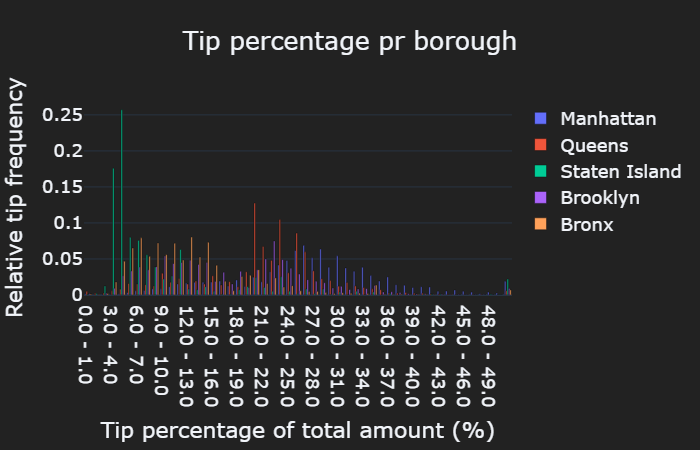

In [11]:
boroughs = ['Manhattan', 'Queens', 'Staten Island','Brooklyn', 'Bronx']

layout = go.Layout(title='Tip percentage pr borough', xaxis_title = "Tip percentage of total amount (%)", yaxis_title = "Relative tip frequency")
fig = go.Figure(layout=layout)

for borough in boroughs:
  tip = df.tip_amount[(df.tip_amount > 0 )& (df.fare_amount > 0) & (df.trip_distance < 30) & (df.PUborough == borough)]
  fare = df.fare_amount[(df.tip_amount > 0 ) &(df.fare_amount > 0 ) & (df.trip_distance < 30)& (df.PUborough == borough)]
  tip_p = 100*tip.values/fare.values

  start = int(tip_p.min())
  size = 1
  # Making a histogram
  largest_value = tip_p.max()
  end = 50
  if largest_value > end:
      hist = np.histogram(tip_p, bins=list(range(start, end+size, size)) + [largest_value])
  else:
      hist = np.histogram(tip_p, bins=list(range(start, end+size, size)) + [end+size])
  
  if borough == boroughs[0]:
    # Adding labels to the chart
    labels = []
    for i, j in zip(hist[1][0::1], hist[1][1::1]):
        if j <= end:
            labels.append('{} - {}'.format(i, j))
        else:
            labels.append('> {}'.format(i))

  fig.add_trace(go.Bar(x = labels, y = hist[0]/len(tip_p), name = borough))

fig.update_layout(barmode='group',
                  template="plotly_dark",
                  plot_bgcolor = "#222",
                  paper_bgcolor = "#222",
                  title_x=0.5,
                  font=dict(
                            size=18,
                        ),
                  hoverlabel=dict(
                      font_size = 18)
                 )
#fig.write_html('images/tip_perc_borough.html')
fig.show()
##################################################### This code part are done by Mikkel ###################################################################

(Mikkel) This figure shows the relative tipping in each borough in New York City and this is splitted into categories 0-50 % of the total amount. All tipping above 50% are put into one category due to some passengers are tipping very large amounts. This figure is chosen as this can show which boroughs that gives the best tips and thereby which borough that would be most beneficial to be in for the taxi driver. The borough indicated is the pickup borough, and thereby where the taxi driver has to be. Also the feature that the user can select and deselect borough he/she are interested in makes it possible for the user to interact with the data and dig deeper into it. 

As the story is to guide the taxi driver to the best earnings, getting the optimal tip amount would therefore be a good way to optimize this. This would then, combined with the geomap displaying the number of pickups pr. zones, indicate where it would be most beneficial to be when the taxi driver needs to find a passenger to pickup and thereby being assured to have customers throughout the working hours. 

### When the taxi driver has to be at work 

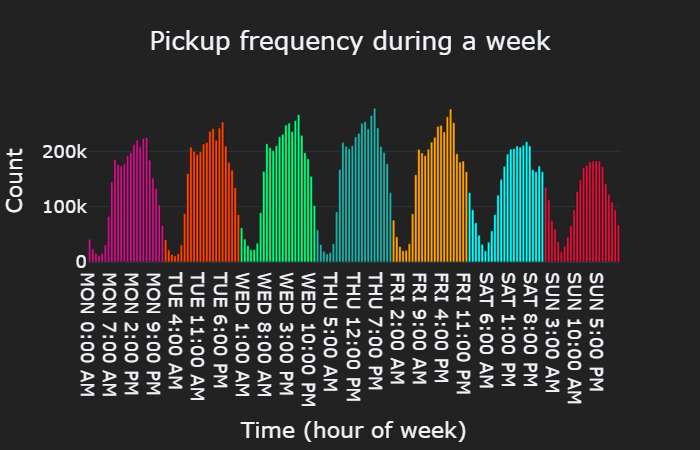

In [12]:
pick_up = df.groupby('pickup_hourofweek').size()


layout = go.Layout(title='Pickup frequency during a week', xaxis_title = "Time (hour of week)", yaxis_title = "Count")
fig = go.Figure(layout=layout)
fig.add_trace(go.Bar(x = l, y = pick_up.values, name = "Pick ups", marker_color = col_scheme))
fig.update_layout(barmode='group',
                  template="plotly_dark",
                  title_x=0.5,
                  plot_bgcolor = "#222",
                  paper_bgcolor = "#222",
                  font=dict(
                            size=18,
                        ),
                  hoverlabel=dict(
                      font_size = 18)
                 )

#fig.write_html('images/pickups_dropoffs_houroftheweek.html')
fig.show()
##################################################### This code part are done by Nicolai ###################################################################

(Nicolai) The next figure shows the total pickups in New York City pr. hour of the week. The colour coding displays when one day ends and the next begin. This is done to make the figure more readable. This figure is included to display what days in a week that have the highest number of available customers, but also to see if there are specific timeframes within a weekday that results in more customers. It is done as hour of the week as this would reveal potential patterns a specific weekdays instead of just a 24-hour cycle. 

A pattern can clearly be determined from this namely that Monday through Friday at 2-6 PM has the highest number of customers and at the night the lowest number of customers are available which is expected.

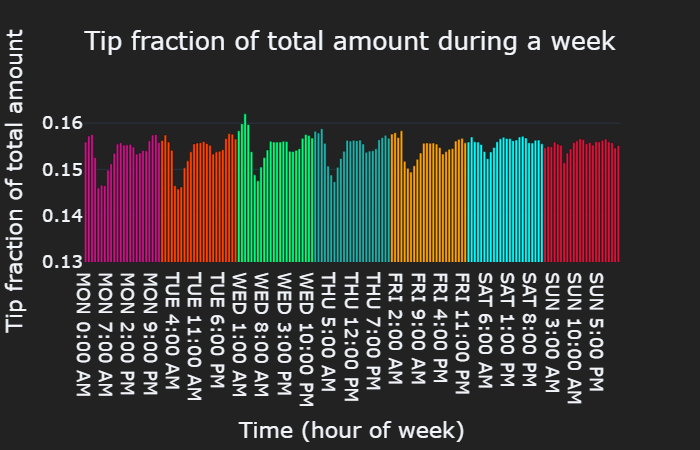

In [13]:
tips_fraction = df[df.tip_amount>0].groupby('pickup_hourofweek')['tip_amount','total_amount'].agg({'tip_amount':'mean',
                                                                                   'total_amount':'mean'})
tips_fraction['fraction'] = tips_fraction.tip_amount.values/tips_fraction.total_amount.values

layout = go.Layout(title='Tip fraction of total amount during a week', xaxis_title = "Time (hour of week)", 
                   yaxis_title = "Tip fraction of total amount")
fig = go.Figure(layout=layout)
fig.add_trace(go.Bar(x = l, y = tips_fraction.fraction.values, marker_color = col_scheme))
fig.update_layout(template="plotly_dark",
                  yaxis_range=[0.13,0.165],
                  title_x=0.5,
                  plot_bgcolor = "#222",
                  paper_bgcolor = "#222",
                  font=dict(
                            size=18,
                        ),
                  hoverlabel=dict(
                      font_size = 18)              
                 )
fig.show()
#fig.write_html('images/tip_fraction_houroftheweek.html')
##################################################### This code part are done by Mikkel ###################################################################

(Mikkel) The figure presents how much the passengers tip as a fraction of the total amount each hour of the week. Again the color coding is done to make it more easy to separate the days. The figure is included as it is not enough to know when the customers are present, but we also need to know when people are more prone to tip higher amounts. 
This figure reveals that there are a clear pattern of tipping, and it appears that the passengers are more prone to tip more between 8PM and 3AM Monday through Friday whereas the tipping pattern appear to be more constant in the Weekends. 

By combining this with when the passengers are available some optimal timeframes for working can be established. 

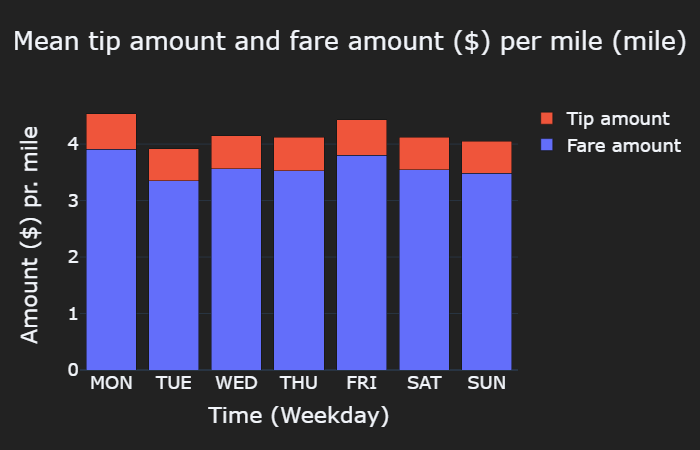

In [14]:
price_pr_mile = df.groupby('pickup_dayofweek')[['trip_distance','tip_amount','fare_amount']].agg({'trip_distance': 'mean',
                                                                           'tip_amount': 'mean',
                                                                           'fare_amount': 'mean'})

price_pr_mile['tip_pr_mile'] = price_pr_mile.tip_amount.values / price_pr_mile.trip_distance.values
price_pr_mile['fare_amount_pr_mile'] = price_pr_mile.fare_amount.values / price_pr_mile.trip_distance.values

layout = go.Layout(title='Mean tip amount and fare amount ($) per mile (mile)', xaxis_title = "Time (Weekday)", 
                   yaxis_title = "Amount ($) pr. mile ")

fig = go.Figure(layout=layout)

fig.add_trace(go.Bar(x = l_weekly, y = price_pr_mile.fare_amount_pr_mile.values, name = 'Fare amount'))
fig.add_trace(go.Bar(x = l_weekly, y = price_pr_mile.tip_pr_mile.values, name = 'Tip amount'))


fig.update_layout(template="plotly_dark",
                  plot_bgcolor = "#222",
                  paper_bgcolor = "#222",
                  title_x=0.5,
                  barmode='stack',
                  font=dict(
                            size=18,
                        ),
                  hoverlabel=dict(
                      font_size = 18)                   
                 )
fig.show()
#fig.write_html('images/price_pr_mile.html')
##################################################### This code part are done by Nicolai ###################################################################

(Nicolai) The figure shows the total price pr. mile for each day of the week. This can further be split into fare amount or tip amount by the user. This is also adds a user interface and lets the user interact with the data on the website. This is added to let the user easily get an overview of specific temporal patterns for when the passenger have higher fare and tip amount. It can easily be seen that Monday has the highest price pr. mile whereas Tuesdays has the lowest. This could indicate which day of the week a taxi driver should work. 

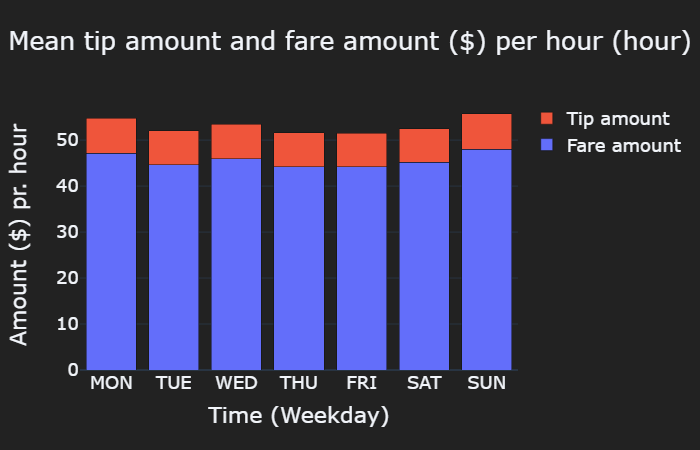

In [15]:
price_pr_mile = df.groupby('pickup_dayofweek')[['trip_distance','tip_amount','fare_amount','duration']].agg({'trip_distance': 'mean',
                                                                           'tip_amount': 'mean',
                                                                           'fare_amount': 'mean',
                                                                           'duration': 'mean'})

price_pr_mile['tip_pr_mile'] = price_pr_mile.tip_amount.values / price_pr_mile.duration.values
price_pr_mile['fare_amount_pr_mile'] = price_pr_mile.fare_amount.values / price_pr_mile.duration.values

layout = go.Layout(title='Mean tip amount and fare amount ($) per hour (hour)', xaxis_title = "Time (Weekday)", 
                   yaxis_title = "Amount ($) pr. hour ")

fig = go.Figure(layout=layout)

fig.add_trace(go.Bar(x = l_weekly, y = price_pr_mile.fare_amount_pr_mile.values, name = 'Fare amount'))
fig.add_trace(go.Bar(x = l_weekly, y = price_pr_mile.tip_pr_mile.values, name = 'Tip amount'))


fig.update_layout(template="plotly_dark",
                  plot_bgcolor = "#222",
                  paper_bgcolor = "#222",
                  title_x=0.5,
                  barmode='stack',
                  font=dict(
                            size=18,
                        ),
                  hoverlabel=dict(
                      font_size = 18)                   
                 )
fig.show()
#fig.write_html('images/price_pr_hour.html')
##################################################### This code part are done by Mikkel ###################################################################

(Mikkel) The figure displays the total price pr. hour the taxi driver has passengers in the car, again the total amount can/are split into the fare amount and tip amount and lets the user interact with the data by selecting/deselecting these. Further, this figure is included as the previous figure otherwise could be misinterpreted. As the price pr. mile can not stand alone, as the price can be due to traffic or similar and the hours the taxi driver uses on a specific distance are needed. This figure can therefore, presented with the other figure, showcase when the taxi driver can earn the most, and clearly Monday is a good day. Sunday has the highest price pr. hour which is interesting as the price pr. mile plot are very low on Sundays. 

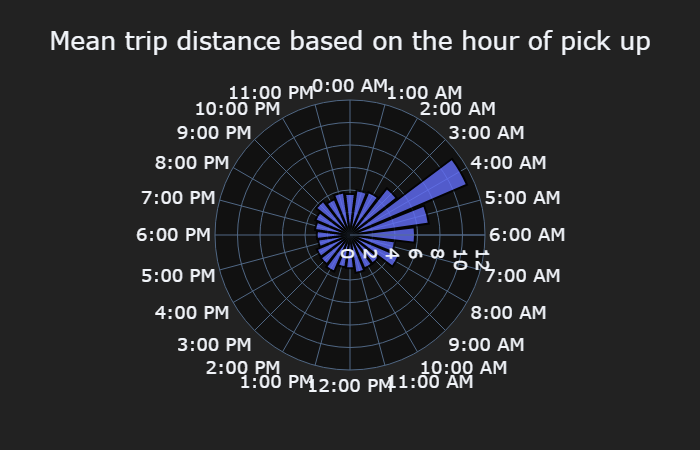

In [16]:
trip_distance = df[df.trip_distance>=0].groupby('pickup_hour')['trip_distance'].agg(trip_distance ='mean')

fig = go.Figure(go.Barpolar(
    r=trip_distance.values.flatten(),
    theta=l_daily,
    #width=10,
    #marker_color=["#E4FF87", '#709BFF', '#709BFF', '#FFAA70', '#FFAA70', '#FFDF70', '#B6FFB4'],
    marker_line_color="black",
    marker_line_width=2,
    opacity=0.8,
    hoverinfo=['r']*24,
    hovertemplate =['Trip distance (miles): %{r} <extra></extra>']*24
    

))

#fig.update_traces(base=l_daily[])

fig.update_layout(
    template="plotly_dark",
    polar = dict(
        radialaxis = dict(range=[0, 12], showticklabels=True, ticks=''),
        angularaxis = dict(showticklabels=True, ticks='', direction = 'clockwise',
                          )
    ),
    plot_bgcolor = "#222",
    paper_bgcolor = "#222",
    polar_angularaxis_rotation=90,
    title = 'Mean trip distance based on the hour of pick up',
    title_x=0.5,
    font=dict(
            size=18,
        ),
    hoverlabel=dict(
      font_size = 18)  
)

fig.show()
#fig.write_html('images/daily_mean_trip_distance.html')
##################################################### This code part are done by Nicolai ###################################################################

(Nicolai) This shows the mean trip distance as a function of the hour of pickup. This is done as a polar plot as this should ease the reading of it. The figure has the form as a clock and the hours goes clockwise which should make it easy to read. This is included as it can show the the taxi driver what hours of a day that would result in long trips with the passenger. Some taxi drivers may prefer short or long trips and this should help them in navigating what time of the day that thereby would result in the correct customers for them. 
Some taxi drivers may prefer to have a lot of short trips, and others may prefer fewer passengers but instead long trips. 

It can clearly be seen that the early morning trips at 4-5AM results in the longest trips compared to the rest of the time frames. 

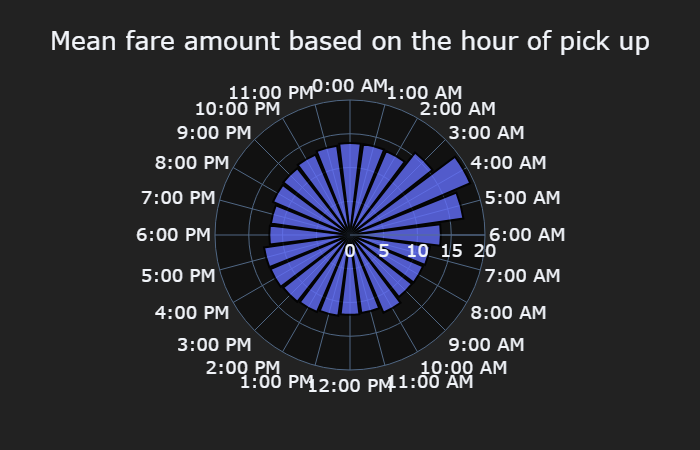

In [24]:
total_amount_daily = df[df.trip_distance>0].groupby('pickup_hour')['fare_amount'].agg(trip_distance ='mean')

fig = go.Figure(go.Barpolar(
    r=total_amount_daily.values.flatten(),
    theta=l_daily,
    #width=10,
    #marker_color=["#E4FF87", '#709BFF', '#709BFF', '#FFAA70', '#FFAA70', '#FFDF70', '#B6FFB4'],
    marker_line_color="black",
    marker_line_width=2,
    opacity=0.8,
    hoverinfo=['r']*24,
    hovertemplate =['Fare Amount: %{r} <extra></extra>']*24
    

))


fig.update_layout(
    template="plotly_dark",
    polar = dict(
        radialaxis = dict(range=[0, 20], showticklabels=True, ticks=''),
        angularaxis = dict(showticklabels=True, ticks='', direction = 'clockwise',
                          )
    ),
    plot_bgcolor = "#222",
    paper_bgcolor = "#222",
    polar_angularaxis_rotation=90,
    title = 'Mean fare amount based on the hour of pick up',
    title_x=0.5,
    font=dict(
            size=18,
        ),
    hoverlabel=dict(
      font_size = 18)  
)

fig.show()
#fig.write_html('images/daily_mean_fare_amount.html')
##################################################### This code part are done by Mikkel ###################################################################

(Mikkel) This figure present the mean fare amount as a function of the pickup hour, again it is presented as a clock to make it easy to interpret. 

As the trip distance not neccesarily determines the trip price, it is wanted to show the taxi drivers whether some of these trips may result in large total amounts. This plot are therefore included, and it can easily be seen that the price and distance follows each other very good. 

### Who should the taxi driver pick as customers

It was also wanted to investigate if the payment type could affect the tipping behaviour but as almost none of the taxi drivers register any tips from cash payment this was not possible to do. 

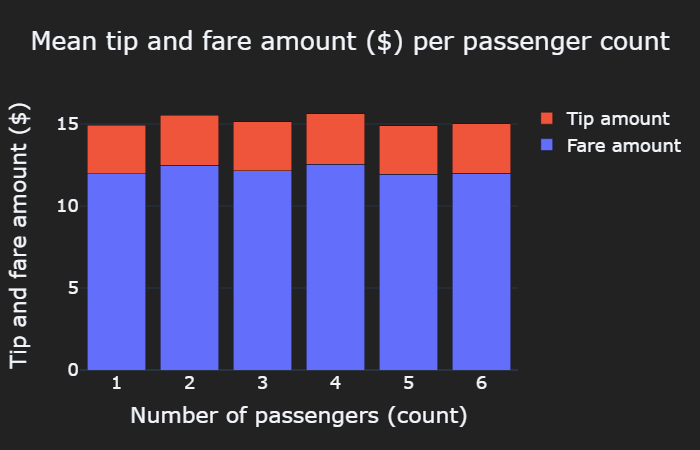

In [25]:
passengers = df[(~df.passenger_count.isin([0,7,8,9,np.nan])) & (df.tip_amount >0)].groupby('passenger_count')[['tip_amount',
                                                                                  'fare_amount',
                                                                                  'DOzone']].agg({
                                                                           'tip_amount': 'mean',
                                                                           'fare_amount': 'mean',
                                                                           'DOzone':'count'
                                                                           })
passengers.index = passengers.index.astype(int)

layout = go.Layout(title='Mean tip and fare amount ($) per passenger count', xaxis_title = "Number of passengers (count)", 
                   yaxis_title = "Tip and fare amount ($) ")

fig = go.Figure(layout=layout)

fig.add_trace(go.Bar(x = passengers.index, y = passengers.fare_amount.values, name = 'Fare amount'))
fig.add_trace(go.Bar(x = passengers.index, y = passengers.tip_amount.values, name = 'Tip amount'))


fig.update_layout(template="plotly_dark",
                  plot_bgcolor = "#222",
                  paper_bgcolor = "#222",
                  title_x=0.5,
                  barmode='stack',
                  font=dict(
                            size=18,
                        ),
                  hoverlabel=dict(
                      font_size = 18)                   
                 )
fig.show()
#fig.write_html('images/price_pr_passengers.html')
##################################################### This code part are done by Nicolai ###################################################################

(Nicolai) This figure presents the total amount (and split into fare amount and tip amount) as a function of the number of passengers that the taxi driver has in the cab. The idea is to investigate if the number of passengers has an effect on the tipping pattern. From this figure there is no clear tipping pattern based on the number of passengers. This figure is included to tell the taxi driver that this is not something that he/she needs to think about and therefore don't spend time/energy on this.

The taxi driver can therefore focus on the other potential ways to maximize the earnings. 

### Feature importance from the Random Forest regression

Most of the feature importance has already been investigated including: pickup and dropoff location and how they affect the tipping, the number of passengers, trip duration, trip distance and fare amount. The trip speed has though not been investigated and it is therefore wanted to determine how this affects the tipping behaviour.

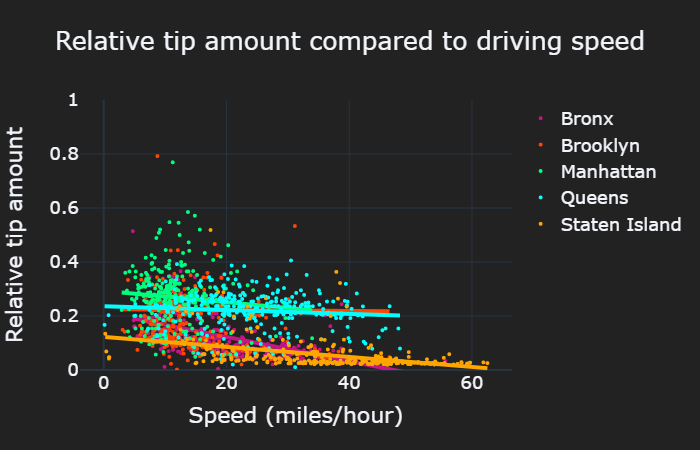

In [26]:
df['speed'] = df['trip_distance'].div(df['duration'])
cols = ['speed','tip_amount','fare_amount']

boroughs = ['Manhattan', 'Queens', 'Staten Island','Brooklyn', 'Bronx']

layout = go.Layout(title='Relative tip amount compared to driving speed', xaxis_title = "Speed (miles/hour)", yaxis_title = "Relative tip amount")
fig = go.Figure(layout=layout)

grp = df.groupby('PUborough')
i = 0

col = ['mediumvioletred',
       'orangered',
       'springgreen',
       'aqua',
       'orange']

for name, group in grp:
    if name == 'EWR':
        continue
    
    plot_df = group[(group.speed < 65) & (group.speed > 0) & 
                    (group.tip_amount >0) & (group.fare_amount > 0)][cols].reset_index(drop=True).sample(n=300,
                                                                                                         axis = 0,
                                                                                                       random_state = 42)
    
    plot_df['rel_tip_amount'] = plot_df.tip_amount.div(plot_df.fare_amount)
    
    fig.add_trace(go.Scatter(x = plot_df.speed, 
                  y = plot_df.rel_tip_amount, name = name, mode='markers',marker=dict(size = 4, color = col[i])))
    
    
    help_fig = px.scatter(plot_df, x="speed", y="rel_tip_amount", trendline="ols")
    x_trend = help_fig["data"][1]['x']
    y_trend = help_fig["data"][1]['y']

    fig.add_trace(go.Scatter(x=x_trend, y=y_trend, showlegend = False, 
                            line=dict(color=col[i], width=4)))
    
    i += 1
        
        
fig.update_layout(barmode='group',
              template="plotly_dark",
              yaxis_range=[0,1],
              plot_bgcolor = "#222",
              paper_bgcolor = "#222",
              title_x=0.5,
              font=dict(
                        size=18,
                    ),
              hoverlabel=dict(
                  font_size = 18)                   
                 )
#fig.write_html('images/tip_vs_speed.html')
fig.show()
##################################################### This code part are done by Mikkel ###################################################################

(Mikkel) This figure shows the fraction of tip amount out of the fare amount against the trip speed. To showcase the relation between these two lines indicating the best residual sum of squares fit in a ordinary least squares fit are provided as well. Also this is split into the borough two investigate if there are specific patterns depending on the borough. There are some clear differences between the behaviour in the different boroughs, but similar for all of them are that there are a negative correlation between tip fraction against the trip speed. 

Again it is possible for the user to interact with the data by selecting/deselecting boroughs. 

This figure is included as it is found from the Random Forest modeling that trip speed was the most important feature in determining of the trip would result in a tip. As there otherwise had not been any investigation of the trip speed this was found as a natural way to investigate this in a way that could be conveyed to the taxi driver. 

<h1 align="center"> 6. Discussion. Think critically about your creation </h1> 

**What went well?**

(Nicolai) We think that we have created a lot of good visualizations that are easy to interpret also for people not being used to data science. We also think the website is very user-friendly and are set-up in a way that guides the user through the story in a good way. It is set-up as a slide show, and thereby determining what information the reader get at a current point. We also think that we have done a good analysis of the data, and that have resulted in good tips and tricks for the taxi drivers for how they can achieve the highest earnings. We think that the tips are well suited and easy to "implement" for the taxi drivers.

**What is still missing? What could be improved?, Why?**

(Mikkel) Further work would clearly be needed to fit the Random Forest regression to predict tip amount but also the classification task predicting whether a trip would result in tip or not. This could be done through balancing the dataset, but also by tuning of hyperparameters such as number of trees, the minimum purity before the tree converges etc. These optimal hyperparameters could be estimated through the use of crossvalidation.

Also it was wanted to introduce other datasets such as whether, as it might be interesting to see how rain, snow, sun affects the tipping pattern as it could be expected that people are more happy for the taxi drivers when the weather are tough. 

It was also wanted to add socio-economic data such as restaurant prices but also how much people earn in each zone in New York and see if a pattern between this and tipping pattern. 

<h1 align="center"> 7. Contributions. Who did what? </h1> 

For each figure and the text block in this notebook, the contribution is stated throughout the notebook.

Mikkel and Nicolai were responsible for the formatting of the website and the explainer notebook.


**For the website the following contribution:** 

Slide 1 "Frontpage"  (Nicolai)

Slide 2 "The goal of this website" (Mikkel)

Slide 3 "Where to operate" (Nicolai)

Slide 4 "Which boroughs in New York City gives the best tip"  (Mikkel)

Slide 5 "Partial conclusion" (Nicolai)

Slide 6 "When to operate" (Mikkel)

Slide 7 "When should I work to achieve the highest ..."  (Nicolai)

Slide 8 "When should i operate to achieve the highest fareamount.." (Mikkel)

Slide 9 "I prefer short trips instead of long trips..." (Nicolai)

Slide 10 "Partial conclusion" (Mikkel)

Slide 11 "Who should i pickup" (Nicolai)

Slide 12 "Partial conclusion" (Mikkel)

Slide 13 "Most important factors for earning a tip" (Nicolai)

Slide 14 "Should i drive fast to earn more tips" (Mikkel)

Slide 15 "Partial conclusion" (Nicolai)

Slide 16 "When and where combined" (Mikkel)

Slide 17 "Conclusion" (Nicolai)

<h1 align="center"> 8. Make sure that you use references when they're needed and follow academic standards. </h1> 



This function to parse the shapefiles *get_lat_lon* was found here: https://chih-ling-hsu.github.io/2018/05/14/NYC


The code used for creating the geomap of NYC with a slider are taken and modified from: https://github.com/JimKing100/SF_Real_Estate_Live/blob/master/SF_Map_Code_Final.ipynb 

This code are used to format the website: https://github.com/dploeger/jekyll-revealjs 